# World Data League 2022

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform and make sure that all the visualisations are visible and everything (text, images, ..) in all deliverables renders correctly.


## 🎯 Challenge
*Identification of Dark Ecological Networks*


## Team: GeoNEAS
## 👥 Authors
* David Gamba
* Melissa Montes
* Juan Diego Arango
* Irune Lansorena
* Santiago Cardona

## 💻 Development

One of the main characteristics of any modern population center is the presence of artificial lighting at night. The use of artificial light has made people more active and cities safer. Sadly, the use of lights at night has been detrimental to biodiversity. Animal species adapted for nightlife are harmed by the presence of a constant barrage of light. A concrete example of this is the Horseshoe bat. In areas with a high presence of light at night, Horseshoe bats have reduced their hunt for food, and lost access to the foraging area. It has been recorded that in areas with high lighting, their buzzes (trace of their hunt in an area) have reduced as much as 60% [1] indicating that they have reduced their hunting in those areas. This is backed by studies that show they avoid areas with levels of light as low as 50 lux [2], which corresponds to the light found in an average family home [3]. The extent of this problem is such that it has been suggested that the decline of the Horseshoe bat in Switzerland was caused in part by artificial lights at night. Those lights pushed the Horseshoe bats out from the foraging area that was then dominated by a competitive species, the Common pipistrelle[4]. Our objective is then to create a dark ecological network. Which is essentially a network of low light areas and corridors that will help bats be more active and roam freely towards food and roosting places in Bristol.

Our team, GeoNEAS, is proposing to create a dark ecological network. This is essentially a path with low light that will help bats be more active and move towards food and roosting places in Bristol.

**Outline**


0. **Data and preprocessing.** Here we explain where to find the big chunk of code that corresponds to data preprocessing.
1. **Exploratory Data Analysis of bats dataset** Here we analyze bats and moths dataset.
2. **Fauna data reports** We develop a cluster analysis to determine locations of bats and moths.
3. **How much to dim lights** Here we determinate allow level of lights for the presence of bats considering current locations and Satellite Images from NASA.
4. **Cost function** To optimize the routes we are going to define the cost functions.
5. **Potential areas measuring** Considering baths and moths likelihood to be in certain zones we use the cost functions to delimite potential areas.
5. **Dark corridors optimization** Using Dijsktra algorithm to minimize routes between bats and moths.
6. **Corridor network optimization** Using minimum spanning trees algorithm the routes are optimize to fully connect the nodes with the minimum necessary paths.
7. **Impact measures** Impact measures are calculated to proof the quality of the solution





### Libraries

We install additional libraries to used in the project

In [ ]:
%%capture
!pip install ortools
!pip install Dijkstar
!pip install -q "pyyaml==5.4.1"
!pip install -q -U altair_data_server contextily hdbscan numpy scipy patsy pandas fiona shapely pyproj rtree ortools
!pip install -q geopandas altair h3pandas kdepy pysal

In [ ]:
import pandas as pd
import geopandas as gpd
import h3pandas
import numpy as np
import networkx as nx

from shapely.geometry import Point
import matplotlib.pyplot as plt

import altair as alt
import matplotlib.pyplot as plt
import folium

from KDEpy import FFTKDE
import hdbscan

from dijkstar import Graph, find_path, algorithm
import json
from tqdm.notebook import tqdm

import random
import seaborn as sns

%pylab inline

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0. Data and preprocessing

On crucial part of theis project was to prepare the data share by British Council and additional information retrieved from open data portals such as Bristol Opne Data, Open Street Maps, and Google Earth Engine.

In the folder "https://storage.googleapis.com/geoneas-bucket/bat-s4/Data_acquisition_notebooks/" you cancheck every notebook of data acquisition biefly explain as:

- **data_preparation_pois** Geographic data from Open Street Maps related to points of interest and buildings was downloaded.
- **data_preparation_streetlights** Geographic data given by Bristol Council was prepared using geopandas library. Information about streetlights, wildlife corridors, dark ecological corridors, amon others.
- **data_acquisition_radiance** Raster data from Satellite Images of NASA was downloaded from Google Earth Engine and used to determinate radiance in Bristol area.
- **data_acquisition_moth and data_acquisition_bats** Information about bats and moths was prepared using geographic columns.
- **data_acquisition_hexagons_SFE** Notebook to conduct spatial feature engineering agragating geographic data to hexagons grids in Bristol.

### 1. Exploratory Data Analysisof bats dataset

In this notebook, we perform an analysis of the information of bats in the area of Bristol. We perform two analysis:

1. Study the distribution of diferent species of bats in the Bristol.
2. Study the number of sightings of the horseshoe bat through time. 

####1.1. Study of the presence of Horseshoe Bats 

The objective of this notebook is to study where are the sightings of different species of bats in Bristol. This is important as the horseshoe bat is the main target of this work.

In [ ]:
path = "/content/drive/MyDrive/GeoNEAS/bat-s4/data/processed_data/bat.geojson"
gdf_bats = gpd.read_file(path)

path = '/content/drive/MyDrive/GeoNEAS/bat-s4/data/processed_data/Bristol_Boundary.geojson'
gdf_bristol = gpd.read_file(path).to_crs('EPSG:4326')

In the counts, we can see that there observations of a wide variety of bats, not only horseshoe bat. **Not only horseshoe**

In [ ]:
gdf_bats.COMMON_NAM.value_counts()

Common Pipistrelle                                                            523
a bat (unidentified)                                                          381
Noctule                                                                       264
Lesser Horseshoe Bat                                                          255
Pipistrelle (45 or 55kHz)                                                     245
Soprano Pipistrelle (55kHz)                                                   192
Serotine                                                                      112
Leisler's Bat                                                                 103
Greater Horseshoe Bat                                                          87
a Myotis bat (unidentified)                                                    67
a Pipistrelle (unidentified)                                                   55
Brown Long-eared Bat                                                           50
Daubenton's Bat 

We create a plot that shows where are Horseshoe bats located and where are the other types of bats located.

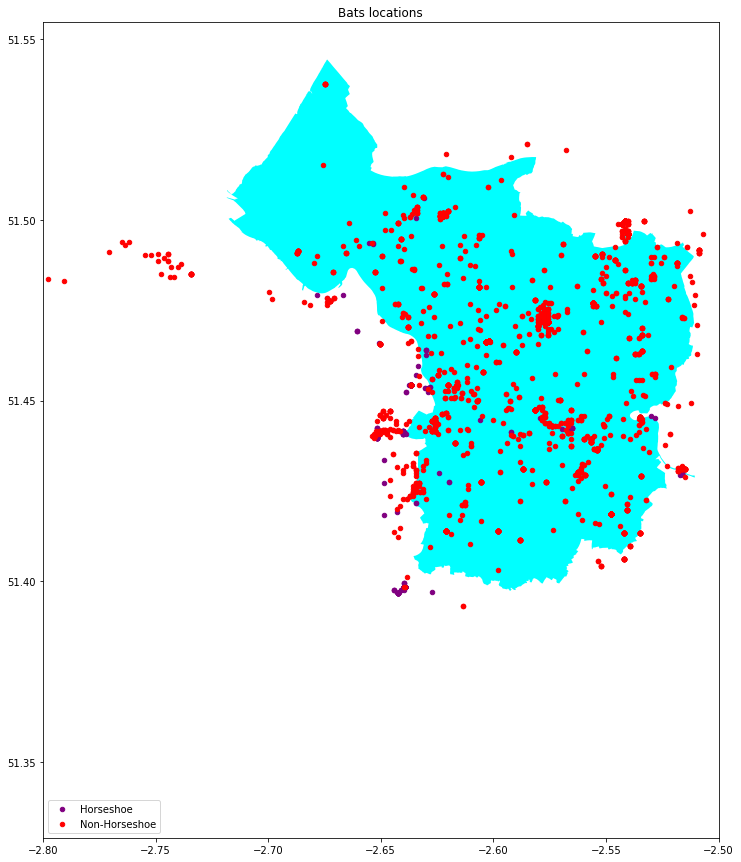

In [ ]:
selected_bats_horseshoe = ['Lesser Horseshoe Bat','Greater Horseshoe Bat']

f, ax = plt.subplots(figsize=(15, 15))

_ = gdf_bristol.plot(ax=ax,color='cyan')

_ = gdf_bats[(gdf_bats.COMMON_NAM.isin(selected_bats_horseshoe))].plot(ax=ax, color='purple', markersize=20,label='Horseshoe')
_ = gdf_bats[~(gdf_bats.COMMON_NAM.isin(selected_bats_horseshoe))].plot(ax=ax, color='red', markersize=20,label='Non-Horseshoe')

ax.legend(loc='lower left')


plt.xlim(-2.8,-2.5)
plt.title("Bats locations")
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Bats_locations.png', dpi = 300)
plt.show()

The main observation that we can make from this plot is that the distribution of Horseshoe bats is mainly at the outskirts of Bristol. Additionally, the sightings of Horseshoe bats do not correspond with the sighting of other species. A purple point (Horseshoe) is not necessarily at the same location where there are red points (Non-Horseshoe). Then, we cannot assume that sighting of other bat species can work as stand-in for the presence of Horseshoe bats.

####1.2. Study of the sightings of Horseshoe Bats through time

We count all the sightings of horseshoe bats in periods of 5 years. Then, we create a plot that shows the number of sighting in every 5 year period.

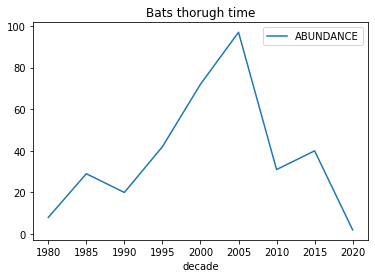

In [ ]:
gdf_horseshoe = gdf_bats[(gdf_bats.COMMON_NAM.isin(selected_bats_horseshoe))].reset_index(drop=True)
gdf_horseshoe.ABUNDANCE = gdf_horseshoe.ABUNDANCE.astype(int)
gdf_horseshoe['decade'] = gdf_horseshoe.apply(lambda x:x.YEAR_DATE - (x.YEAR_DATE%5),axis=1)
gdf_yr = gdf_horseshoe[['ABUNDANCE', 'decade']].groupby(by='decade').sum()


fig = gdf_yr.loc[1980:2020].plot()
plt.title("Bats thorugh time")
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Bats_time.png', dpi = 300)

From the results observed, we can see that there has been decrease in sighting in the last 15 years. This might indicate that the has been a reduction in the overall presence of Horseshoe bats in the area of Bristol.

####1.3.Conclusions

The first conclusion we can make is that Non-Horseshoe bats might not work as stand-in for Horseshoe bats. It seems that species might locate in different locations. This makes sense as different species might compite with each other for resources such as food.

The second conclusion is that, from the the number of sighting of bats in time, it seems that there might be a reduction in the number of Horseshoe bats in Bristol. This is only an estimation made from sighting and might no be conclusive. 

###2. Fauna data reports

In this note

####2.1.Distribution of bats and moths

In [ ]:
BASE_PATH='/content/drive/MyDrive/GeoNEAS/bat-s4/data'

EXPORT_CRS = 'EPSG:4326'
LOCAL_CRS = 'EPSG:27700'

bats = gpd.read_file(f'{BASE_PATH}/processed_data/bat.geojson').to_crs(LOCAL_CRS)
moths = gpd.read_file(f'{BASE_PATH}/processed_data/moth.geojson').to_crs(LOCAL_CRS)

bats['x'] = bats.geometry.x
bats['y'] = bats.geometry.y

moths['x'] = moths.geometry.x
moths['y'] = moths.geometry.y

bats.head()

SCIENTIFIC                   COMMON_NAM  \
0     Pipistrellus pipistrellus (sensu lato)    Pipistrelle (45 or 55kHz)   
1                      Pipistrellus pygmaeus  Soprano Pipistrelle (55kHz)   
2  Pipistrellus pipistrellus (sensu stricto)           Common Pipistrelle   
3                           Nyctalus noctula                      Noctule   
4                         Myotis daubentonii              Daubenton's Bat   

   DATE_OF_RE ABUNDANCE  YEAR_DATE        lat      long              x  \
0  04/07/1995         1       1995  51.440208 -2.569692  360499.995259   
1  01/03/1998         1       1998  51.499176 -2.642457  355499.994985   
2  01/03/1998         1       1998  51.499176 -2.642457  355499.994985   
3  04/07/1995         1       1995  51.440208 -2.569692  360499.995259   
4  06/06/1994         1       1994  51.440679 -2.651707  354799.999352   

               y                       geometry  
0  171400.040317  POINT (360499.995 171400.040)  
1  177999.987814  POINT (355499.995 177999.988)  
2  177999.987814  POINT (355499.995 177999.988)  
3  171400.040317  POINT (360499.995 171400.040)  
4  171499.955593  POINT (354799.999 171499.956)

We filter the species corresponding to horseshoe bats. As per our initial analysis of reports in which we determined that other species might have very different behavior and even non compatible behavior.

In [ ]:
bats.COMMON_NAM.value_counts()

Common Pipistrelle                                                            523
a bat (unidentified)                                                          381
Noctule                                                                       264
Lesser Horseshoe Bat                                                          255
Pipistrelle (45 or 55kHz)                                                     245
Soprano Pipistrelle (55kHz)                                                   192
Serotine                                                                      112
Leisler's Bat                                                                 103
Greater Horseshoe Bat                                                          87
a Myotis bat (unidentified)                                                    67
a Pipistrelle (unidentified)                                                   55
Brown Long-eared Bat                                                           50
Daubenton's Bat 

In [ ]:
selected_bats_horseshoe = ['Lesser Horseshoe Bat','Greater Horseshoe Bat']
bats = bats.loc[lambda x: x.COMMON_NAM.isin(selected_bats_horseshoe)]

In [ ]:
bats_chart = alt.Chart(bats).mark_point(
    clip=False, color='blue', opacity=0.7).encode(
    x=alt.X('x:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', scale=alt.Scale(zero=False)),
    tooltip=['COMMON_NAM', 'YEAR_DATE']
).properties(
    title='Bat reports'
).interactive()

moths_chart = alt.Chart(moths).mark_point(
    clip=False, color='orange', opacity=0.7).encode(
    x=alt.X('x:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', scale=alt.Scale(zero=False)),
).properties(
    title='Moth reports'
).interactive()

bats_chart+moths_chart


alt.LayerChart(...)

In [ ]:
bats = bats.loc[lambda x: (x.geometry.x > 330000)].copy()

Now, we notice a few things:

1. There seem to be indeed points where bats aggregate, we also notice that these 'clusters' do not in general have a clear associated shape, some are more or less spherical while others are more elongated.
2. There are many points that might be strays, single reports that might correspond to a place where bats were seen but that does not correspond to typical behavior. Before aggregating the numbers, we would like to filter such outliers and have an idea of the likelihood of seeing a bat in each of these areas. 

In addition, we would like to be able to delineate those areas, for example generating polygons from the clusters, or marking a set of hexagons if we are working in a grid. Ideally these marked areas should be situated within the dark ecological network.

Following we describe two methods that we tried to estimate the density of bats in bristol and we describe why we chose one of those at the end

####2.2. KDE density estimation

One way we have to better asess the distribution of bats in Bristol is passing the points through a KDE. This gives us a continuous estimate of the probability of bats across the map. We could then 

In [ ]:
data = np.array(list(zip(bats.geometry.x, bats.geometry.y)))
data.shape

(342, 2)

In [ ]:
grid_points = 2**8
kde = FFTKDE(bw=100, kernel='gaussian')
grid, density = kde.fit(data).evaluate(grid_points)

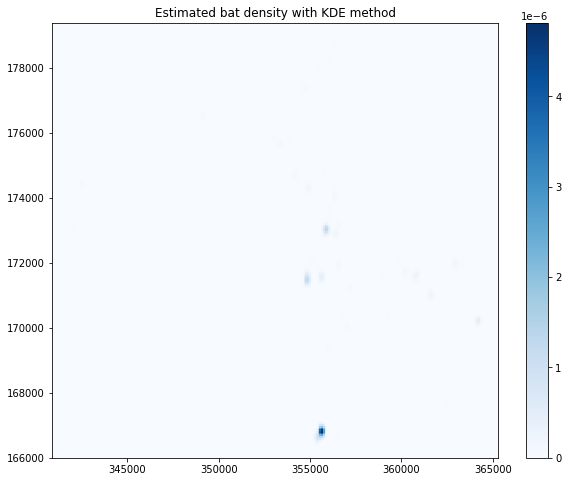

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

# The grid is of shape (obs, dims), points are of shape (obs, 1)
x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
z = density.reshape(grid_points, grid_points).T

z_min, z_max = z.min(), z.max()

c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
ax.set_title('Estimated bat density with KDE method')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

Here, we note that the estimated areas might be too small. One way to deal with this is to change the bandwith of the kernel, making it larger will make a point influence more area beyond. Selecting the bandwith is not simple in this case. Some areas are large with scattered reports and some areas are small with concentrated reports, this would mean that we would likely want to have a way to have a variable bandwidth for the kernel.

In order to deal with this, we will move to another approach using hdbscan

####2.3. HDBSCAN bats
This approach is a variant of dbscan that calculates clusters based on density but that has two particular advantages highly useful for our problem:

1. It has the advantage that we can use it to generate clusters at different scales, to cover cases of scattered reports which might correspond to large activity zones as well as concentrated reports.
2. It can be used to generate probability estimation of belonging to a cluster, and also to classify new points fixing the current clustering assignation.

Running the algorith is very simple, we still have to specify two hyperparameters.

1. The min cluster size or number of reports that might be considered to be a cluster. Since the reporting is very infrequent, we choose a very small minimum. This has the risk of clasifying a few stray reports as a potential activity zone. Better data and reporting could allo us to improve this estimate.
2. cluster selection epsilon is a measure of distance on which two clusters near each other will be merged. We chose 50 meters as a sensible parameter of an area relatively small that could be used by these small bats. Of course this parameter can be further informed by biology experts.

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3, 
    cluster_selection_epsilon=50, 
    prediction_data=True)
clusterer = clusterer.fit(bats[['x', 'y']])

In [ ]:
bats['label'] = clusterer.labels_
bats['likelihood'] = clusterer.probabilities_

How many clusters we have (adding one for the -1 that denotes outliers)

In [ ]:
bats.label.nunique()

22

In [ ]:
alt.Chart(bats).mark_point(clip=False).encode(
    x=alt.X('x:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', scale=alt.Scale(zero=False)),
    color='label:Q',
    opacity='likelihood:Q'
).properties(
    title='Bat reports colored by estimated cluster'
).interactive()

alt.Chart(...)

In this chart we find that sparse clusters have a better chance to be captured, such as the cluster to the upper left of the map, which corresponds to a long line that has historically reported activity.

The cluster assignment will also helpo better determine different foraging areas

In [ ]:
grid_labels, grid_likelihoods = hdbscan.prediction.approximate_predict(clusterer, grid)

Lets plot the soft clusters, we only focus on the likelihood, that is the areas with cluster

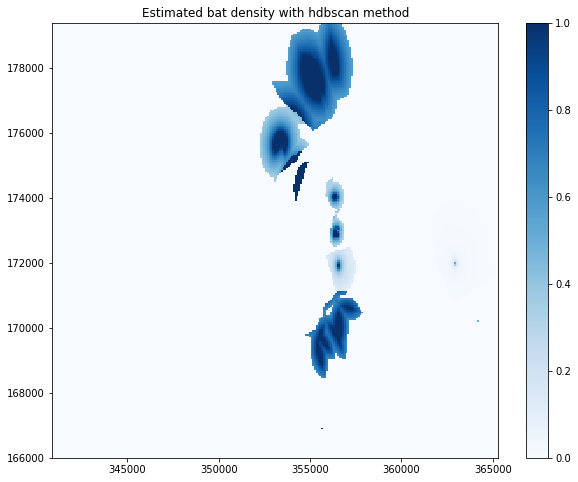

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

# The grid is of shape (obs, dims), points are of shape (obs, 1)
x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
z = grid_likelihoods.reshape(grid_points, grid_points).T

z_min, z_max = z.min(), z.max()

c = ax.pcolormesh(x, y, z, cmap='Blues', vmin=z_min, vmax=z_max)
ax.set_title('Estimated bat density with hdbscan method')
# set the limits of the plot to the limits of the data
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Bats_density_HDBSCAN.png', dpi = 300)
plt.show()

All these records have an assigned cluster with some probability.

In [ ]:
def mesh_to_df(grid_labels, grid_likelihoods, crs):
  return gpd.GeoDataFrame(
    {'label':grid_labels, 'likelihood': grid_likelihoods}, 
    geometry=gpd.points_from_xy(grid[:, 0], grid[:, 1]), crs=crs)

In [ ]:
MINIMUM_LIKELIHOOD = 0.0

bats_grid = mesh_to_df(grid_labels, grid_likelihoods, bats.crs)

bats_grid = bats_grid.query('likelihood > @MINIMUM_LIKELIHOOD')

####2.4. HDBSCAN moths

Now we perform the analysis in moths locations

In [ ]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=3, 
    cluster_selection_epsilon=100, 
    prediction_data=True)
clusterer = clusterer.fit(moths[['x', 'y']])

In [ ]:
moths['label'] = clusterer.labels_
moths['likelihood'] = clusterer.probabilities_

In [ ]:
moths.label.nunique()

32

In [ ]:
alt.Chart(moths).mark_point(clip=False).encode(
    x=alt.X('x:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', scale=alt.Scale(zero=False)),
    color='label:Q',
    opacity='likelihood:Q'
).properties(
    title='Moth reports colored by assigned cluster'
).interactive()

alt.Chart(...)

All these records have an assigned cluster with some probability.

In [ ]:
grid_labels, grid_likelihoods = hdbscan.prediction.approximate_predict(clusterer, grid)

moths_grid = mesh_to_df(grid_labels, grid_likelihoods, bats.crs)

moths_grid = moths_grid.query('likelihood > @MINIMUM_LIKELIHOOD')

####2.5. Mapping to polygons

From this data, we can proceed to generate the average likelihood of bats per hexagon 

In [ ]:
def get_h3_gdf(gdf, resolution=10):
  aggs = {'label': lambda x: pd.Series.mode(x)[0], 'likelihood': 'mean'}

  return (gdf
          .query('label!=-1')
          .to_crs(EXPORT_CRS)
          .h3.geo_to_h3_aggregate(resolution, operation=aggs))

In [ ]:
HEX_RESOLUTION=9

#####2.5.1. Bats

Lets transform the continuous estimate of labels to our h3 grid mesh at resolution 10

In [ ]:
bats_hex = get_h3_gdf(bats_grid, HEX_RESOLUTION)
bats_hex.head()

label  likelihood  \
h3_09                                
8919580ca23ffff      2    0.598905   
8919580ca27ffff      2    0.594898   
8919580ca2bffff      2    0.670899   
8919580ca2fffff      2    0.687746   
8919580ca3bffff      2    0.586448   

                                                          geometry  
h3_09                                                               
8919580ca23ffff  POLYGON ((-2.62517 51.51219, -2.62726 51.51116...  
8919580ca27ffff  POLYGON ((-2.62204 51.50972, -2.62413 51.50868...  
8919580ca2bffff  POLYGON ((-2.62987 51.51188, -2.63196 51.51084...  
8919580ca2fffff  POLYGON ((-2.62674 51.50940, -2.62883 51.50837...  
8919580ca3bffff  POLYGON ((-2.62830 51.51466, -2.63039 51.51363...

Each polygon has associated the most prevalent label, and also the average likelihood of the points belonging to a cluster. This allows us to determine what parts of the h3 grid might be more likely than others

In [ ]:
bats_hex.likelihood.quantile(np.linspace(0,1,11))

0.0    0.007511
0.1    0.010747
0.2    0.019204
0.3    0.290642
0.4    0.442254
0.5    0.606042
0.6    0.685052
0.7    0.750627
0.8    0.844543
0.9    0.957848
1.0    1.000000
Name: likelihood, dtype: float64

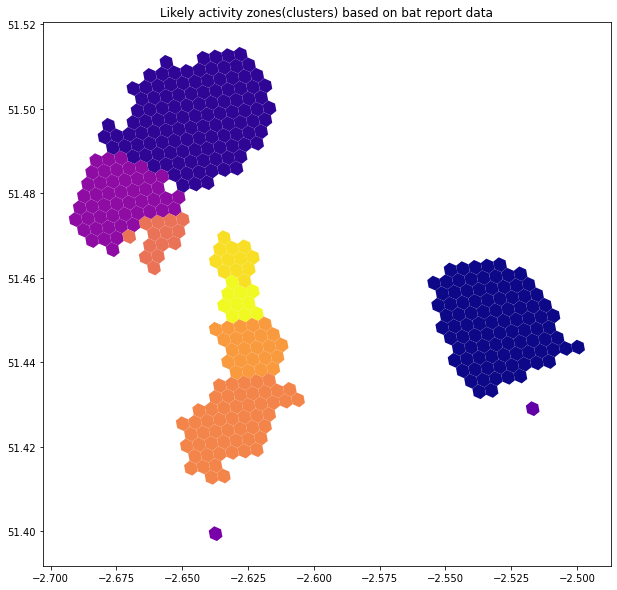

In [ ]:
fig, ax = plt.subplots(figsize=(13,10))
bats_hex.plot(column='label', ax=ax, cmap='plasma')
ax.set_title('Likely activity zones(clusters) based on bat report data')
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Bats_Cluster_HDBSCAN.png', dpi = 300)

#####2.5.2. Moths


Now lets do the same with moths

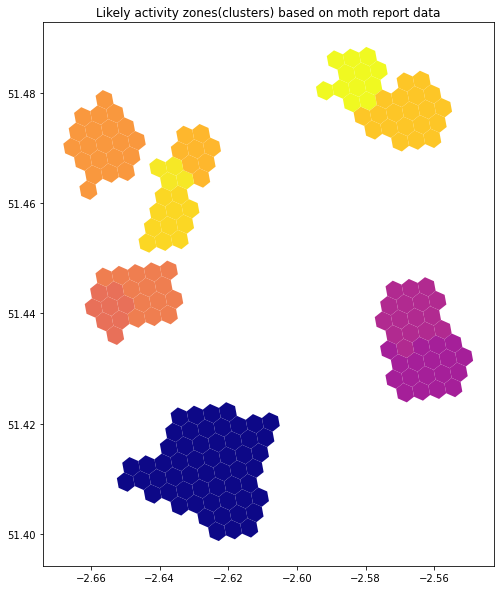

In [ ]:
moths_hex = get_h3_gdf(moths_grid, HEX_RESOLUTION)

fig, ax = plt.subplots(figsize=(13,10))
moths_hex.plot(column='label', ax=ax, cmap='plasma')
ax.set_title('Likely activity zones(clusters) based on moth report data')
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Moths_Cluster_HDBSCAN.png', dpi = 300)

In [ ]:
m = folium.Map(location=[bats_hex.unary_union.centroid.y, bats_hex.unary_union.centroid.x], zoom_start=13)

folium.GeoJson(
        data=f'{BASE_PATH}/optimization_input/bats_hex_{HEX_RESOLUTION}.geojson',
        tooltip=folium.GeoJsonTooltip(fields=['label', 'likelihood']),
        highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
        style_function=lambda feature: {
            # 'fillColor': risk_color_function(feature),
            'color': 'blue',
            'weight': 0.1,
            'fillOpacity': feature['properties']['likelihood']*0.8},
).add_to(m)

folium.GeoJson(
        data=f'{BASE_PATH}/optimization_input/moths_hex_{HEX_RESOLUTION}.geojson',
        #tooltip=folium.GeoJsonTooltip(fields=['h3_polyfill', 'cases', 'risk_index'],
        #                              aliases=['area_id', 'Cases', 'risk_index']),
        highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
        style_function=lambda feature: {
            # 'fillColor': risk_color_function(feature),
            'color': 'orange',
            'weight': 0.1,
            'fillOpacity': feature['properties']['likelihood']*0.8},
).add_to(m)

folium.LayerControl(collapsed=True).add_to(m)

m

####2.5. Conclusions

On this section, we derived estimates of the areas which bats could potentially dwell be it either based on reports of bats or one of their primary food species. Since the reports carry noise and are in general sparse, we opted for using a model to estimate areas of high density of reports. 

With this estimates, we can assign boundaries of potential areas to be added to the ecological network. The following work is to connect these areas through corridors.

This method is generalizable to other species contingent on the fact that there are enough reports, which we also noted that for the case of the horseshoe bat are limited.

###3. How much to dim lights

On this section, we are going to derive an estimate of how much light is too much for our horseshoe bats based on the current sightings and the radiance map.

The idea is to find the average radiance in the places that bats frequent. Under the assumption that bats are generally reported in the areas they frequent, then well see what is the average radiance of the places that the bats support, which we can call required radiance. With that, we can form a map of the difference of radiance of all hexagons to the required radiance. Positive differences indicate that in order to promote bats in the area(from the lightning perspective) the radiance should be reduced. While negative values of difference indicate that the variance is appropiate for horseshoe bats.

In [ ]:
BASE_PATH='/content/drive/MyDrive/GeoNEAS/bat-s4/data'

EXPORT_CRS = 'EPSG:4326'
LOCAL_CRS = 'EPSG:27700'

HEX_RESOLUTION = 9

H3_IDS = {9: 'h3_09', 10: 'h3_10'}
H3_ID = H3_IDS[HEX_RESOLUTION]

####3.1. Analyzing the radiance on areas where bats are reported

Lets load the radiance map and the estimated clusters of bats

In [ ]:
radiance = gpd.read_file(f'{BASE_PATH}/optimization_input/radiance_hex_{HEX_RESOLUTION}.geojson')
bats = gpd.read_file(f'{BASE_PATH}/optimization_input/bats_hex_{HEX_RESOLUTION}.geojson')

Lets see the current radiance distribution

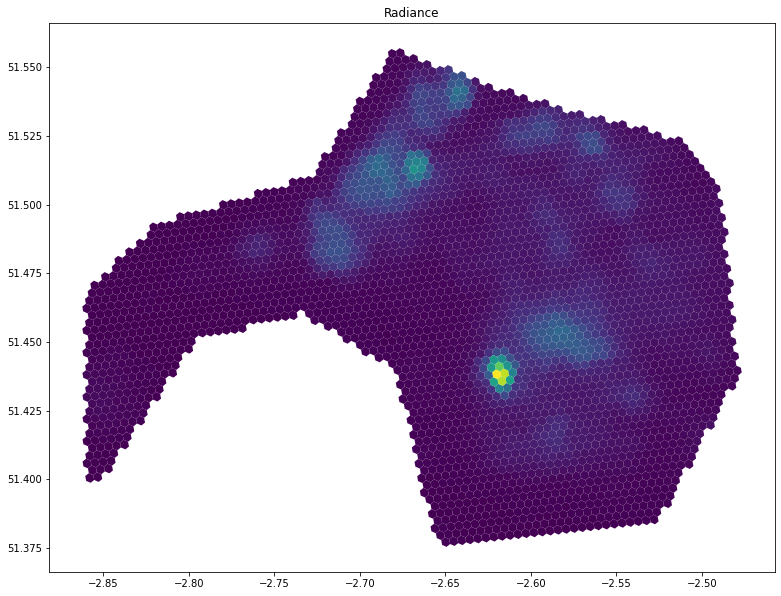

In [ ]:
fig, ax = plt.subplots(figsize=(13,13))
radiance.plot(column='radiance', ax = ax)
plt.title("Radiance")
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Radiance.png', dpi = 300)

Well filter the density to only those with a relatively high likelihood of belonging to a cluster.

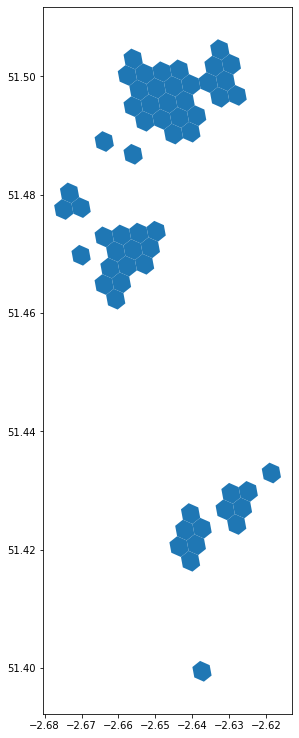

In [ ]:
fig, ax = plt.subplots(figsize=(13,13))
bats = bats.query('likelihood>0.9')
bats.plot(ax = ax)

With this, we filter the radiance map to only those registers where bats are very likely to locate.

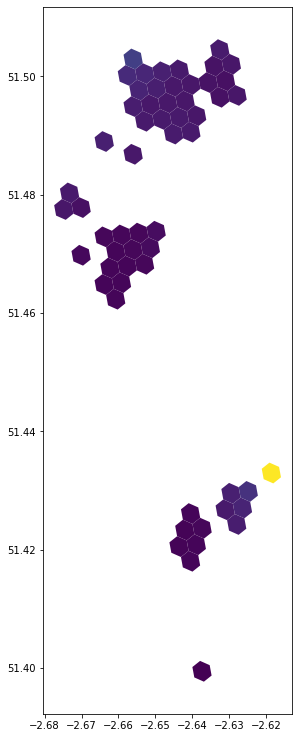

In [ ]:
fig, ax = plt.subplots(figsize=(13,13))
bats_radiance = radiance.loc[lambda x: x[H3_ID].isin(bats[H3_ID])]
bats_radiance.plot(column='radiance', ax = ax)

What is the distribution of this variable?

In [ ]:
required_radiance = bats_radiance.radiance.mean()
required_radiance

7.541337958697615

####3.2. Generating a measure or cost of dimming

With the previous insights, we have found a level, or threshold that bats will tollerate in order to dwell in certain area. 

Now, we assume that in order to incorporate an area into the dark ecological networks for bats to ream, the lightning level should be set to the tolerance threshold. Comparing the current lightning level of an area to this threshold we can estimate a cost, and we estimate this cost proportional to the original value of radiance/light in the area. This would make very bright areas reflect a higher cost of being incorporated into the network that moderately lit areas. At least only from the light perspective.

We also note that in the calculation, if the area is already below the threshold, then there ahould be no cost (from light perspective) since the area is already on an appropiate level of light for bats. 

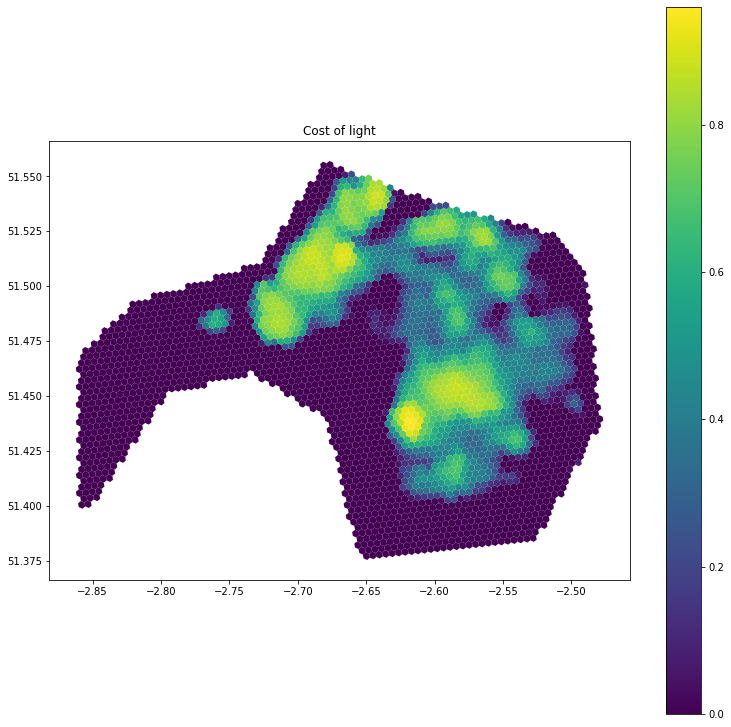

In [ ]:
radiance['diff_w_required'] = radiance.radiance - required_radiance
radiance['cost_light'] = np.where(radiance.diff_w_required > 0, radiance.diff_w_required/radiance.radiance, 0)

fig, ax = plt.subplots(figsize=(13,13))
radiance.plot(column='cost_light', ax=ax, legend = True)
plt.title("Cost of light")
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Cost_light.png', dpi = 300)

####2.3. Conclusions

In this section we dereived a threshold for the radiance that bats could tolerate. This measure could be further tuned or improved with the input of biology and ecology experts. 

We note that the approach could be extended for other night creatures that might have different tolerance levels, as well as measures for other variables (such as amount of trees), which influence the dwelling of other species in order to understand what an area should reach in order to be annexed to ecological networks.

###4. Cost function definition

We want to optimize routes to connect bats to the moths minimizing the impact to the humans. We are going to perform an optimization analysis consiering an hexagon grid. In the data acquisition notebook and the dim light section we add some important variables to the hexagons grids. 

In this notebook we are going to create cost functions as weights in the hexagons in orther to optmize in the next section. We will create three cost functions considering resistance and impact variables. Resistance variables are related to biological and domain knowledge about baths. Buildings, trees or rivers presence are related to resistance variables. On the other hand, impact variables are related to humans and it will be part of decission-makers and public policy decissions. Points of interest, cost of lights and crimes are related to impact variables

In [ ]:
BASE_PATH = "/content/drive/MyDrive/GeoNEAS/bat-s4/data/optimization_input/"

H3_RESOLUTION = 9

hex = gpd.read_file(BASE_PATH + f"hex{H3_RESOLUTION}.geojson")

hex.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   h3_polyfill             3019 non-null   object  
 1   index                   3019 non-null   int64   
 2   id                      3019 non-null   int64   
 3   N_lights                3019 non-null   int64   
 4   N_trees                 3019 non-null   int64   
 5   N_pois                  3019 non-null   int64   
 6   River                   3019 non-null   int64   
 7   Perc_green              3019 non-null   float64 
 8   Perc_buildings          3019 non-null   float64 
 9   Perc_wildlifecorridors  3019 non-null   float64 
 10  burglary_hex            3019 non-null   float64 
 11  violence_sexual_hex     3019 non-null   float64 
 12  radiance                3019 non-null   float64 
 13  diff_w_required         3019 non-null   float64 
 14  cost_light      

#### 4.1. Cost function *C(hex)*

A cost function *C(hex)* per hexagon grid is required and it should contain two parts: 1) facility for a bat to pass through the area, and 2) the negative impact for human beings of generate a corridor in the area. Consequently the cost function depends of two things: baths resistance (R) and human impact (I).

> *C(R(hex), I(hex))*

Each part could have a particular cost function depending of the variables. The resistance part should consider domain knowledge (baths experts and biologist) while the impact part should consider decission-makers and public policy opinions. At the end, the cost function will be determinate by:

                           
>  *C(hex) =$\alpha$*R(hex) + (1 - $\alpha$)*I(hex)*

$\alpha$ represents the weights of the resistance variables consequently an $\alpha$ equal to 0.5 means an equal proportion or importance for impact and resistance variables.

Now we are going to explain the variables considered in the cost function

##### Resistance variables *R(hex)*

- n_trees [resistance] number of trees in the hexagons. The cost function will maximize their use becasue the bats prefer this zones for commute.

- River [resistance] dummy variable that checks if a river cross the hexagon. Bats prefere this paths.
- Perc_green [resistance] percentage of green areas respect the hexagon areas. Bats prefer this zones.
- Perc_buildings [resistance] percentage of buildings compare with the hexagons area. Bats will avoid these zones.
- Perc_wildlifecorridors [resistance] percentage of wildlife corridors respect the hexagon areas. Bats prefer this zones.

#### Impact variables *R(hex)*

- n_pois [impact] dummy variable with points of interest where lights could be not turn off. The cost function avoid these zones.
- burglary_hex and violence_sexual_hex [impact] number of crimes per type in the hexagon. Decission-makers will pay attention to these metric because security concerns.

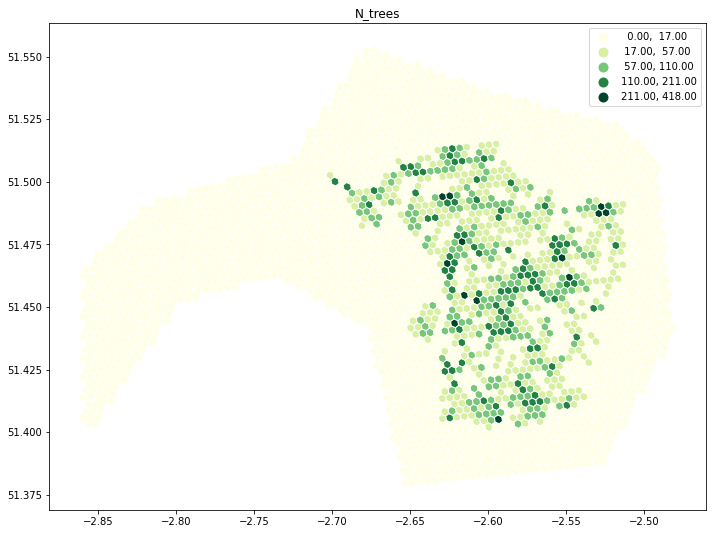

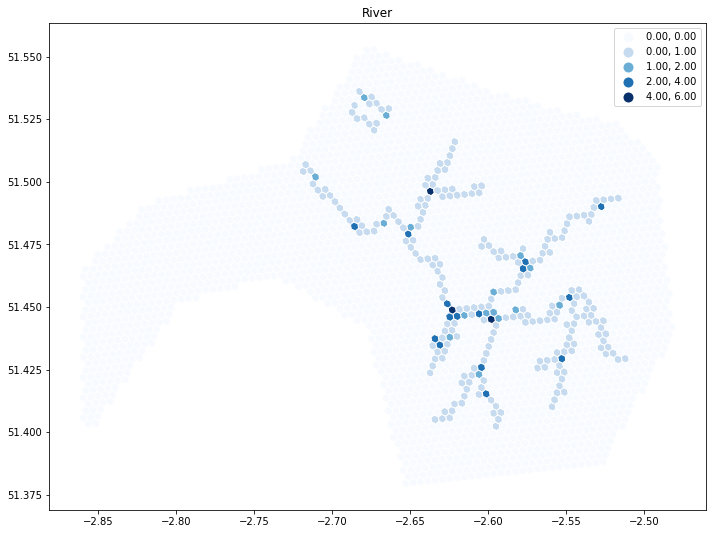

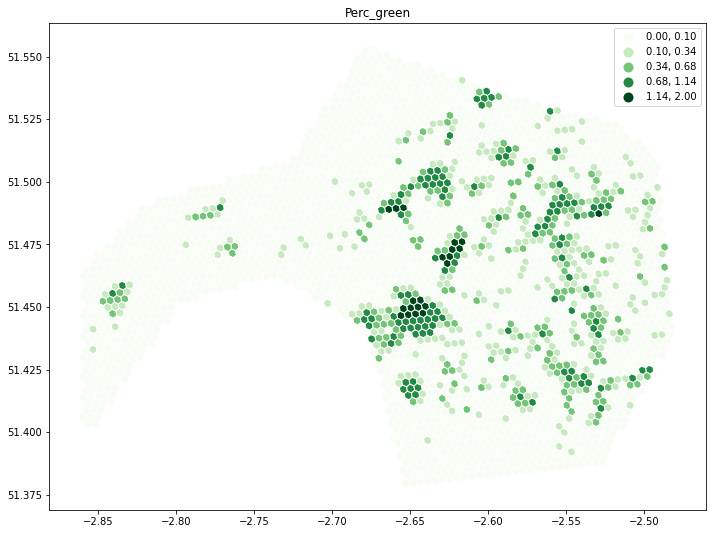

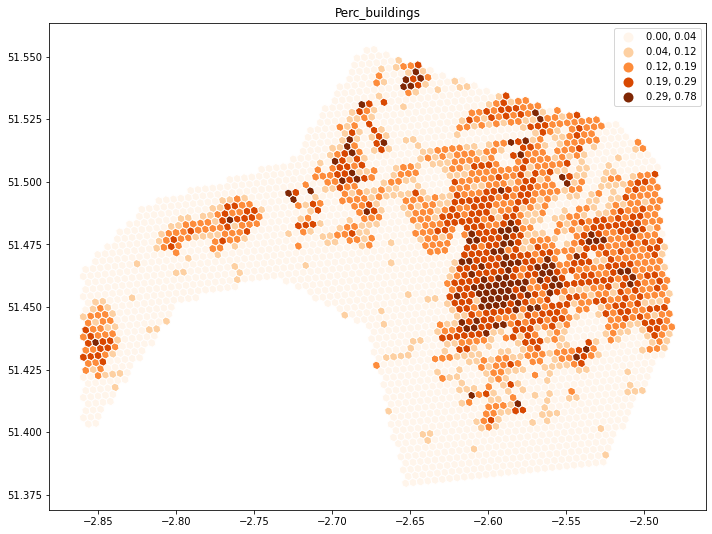

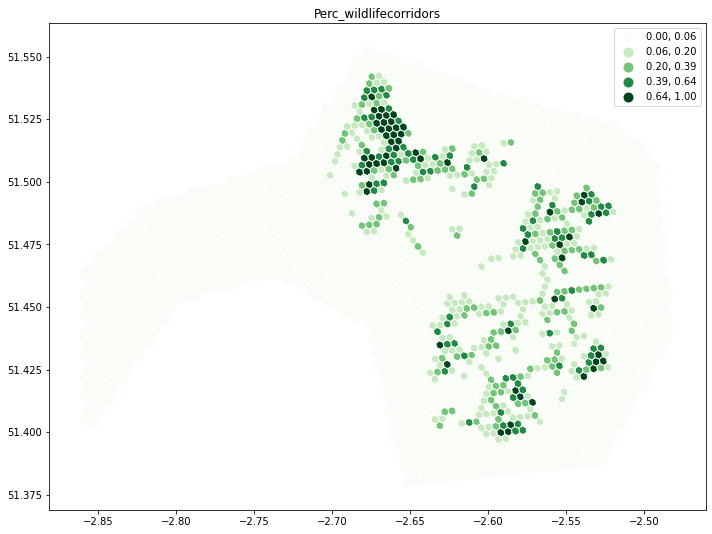

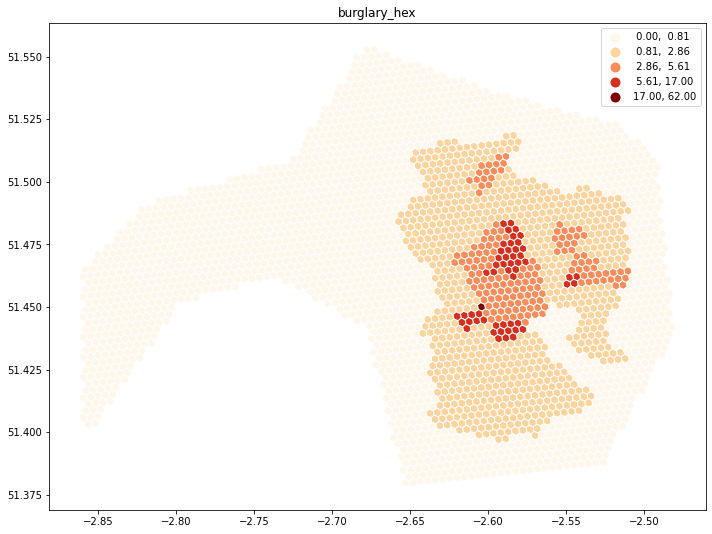

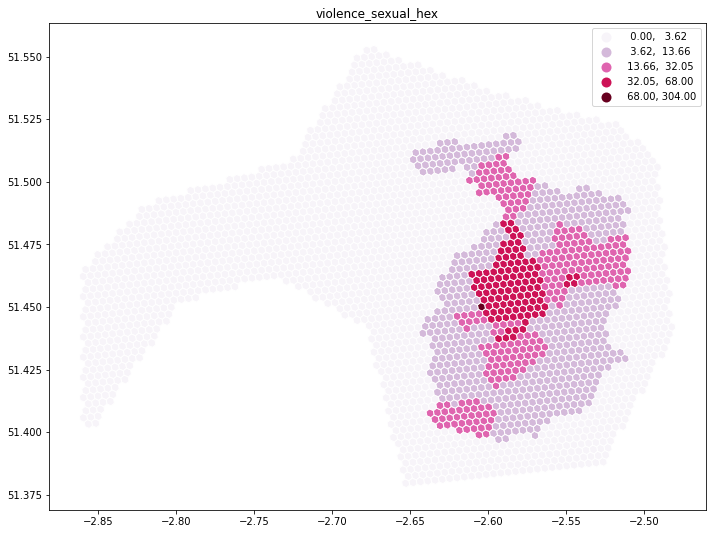

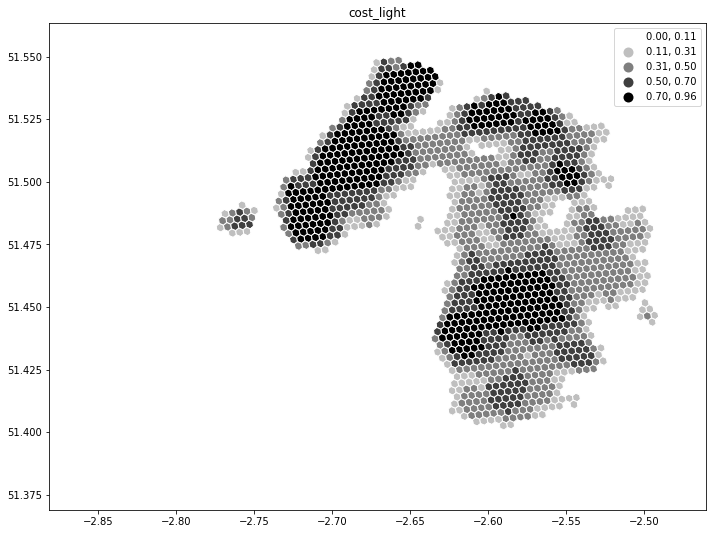

In [ ]:
variables = ['N_trees', 'River', 'Perc_green', 'Perc_buildings', 'Perc_wildlifecorridors',
            'burglary_hex', 'violence_sexual_hex', "cost_light"]

colors = ["YlGn", "Blues", "Greens", "Oranges", "Greens", "OrRd", "PuRd", "binary"]

for i,j in zip(variables, colors):

  fig, ax = plt.subplots(figsize=(10,10))

  hex.plot(column = i,
           legend = True,
           edgecolor = "white",
           cmap = j,
           ax = ax,
           scheme = 'naturalbreaks')

  plt.title("{}".format(i))
  plt.tight_layout()
  plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/cost_function_{i}.png', dpi = 300)
  plt.show()

The figures show the geographical distribution per variable, this allow us to identify potential routes for baths and identify dark ecollogical corridors. The most important features in this maps are related to buildings coverage, rivers, points of interest and cost of light because are related to resistance and impact variables.

####4.2. Variables normalization

In order to calculate the cost function we are going to normalize the variables between 0 and 1. 

First we need to generate the dummy variables for number of pois and rivers because we want to evaluate if the area contains at least a river or a point of interest that we want to avoid in the route

In [ ]:
hex['N_pois'][hex['N_pois'] > 0] = 1
hex['River'][hex['River'] > 0] = 1

hex_norm = hex.copy()

var_norm = ['N_trees', 'N_pois', 'River', 'Perc_green', 
            'Perc_buildings', 'Perc_wildlifecorridors',
            'burglary_hex', 'violence_sexual_hex', 'cost_light']

for i in var_norm:

  min = hex_norm[i].min()
  max = hex_norm[i].max()

  hex_norm[i] = [(x-min)/(max-min) for x in hex[i]]

####4.3. Cost function definition

We need to define the cost functions considering resistance and impact parts. 

**Resistance**

Considering the literature reviewed the buildings generate barries in the baths journey consequently they are going to avoid zones with high percentages of buildings. In this case we are goin to restrict areas with building percentages higher than percentile 75 adding an infinite cost. On the other hand, rivers are zones with high probability of bat use for commute consequently the cost will be minimize by 50% when a river cross an hexagon. The other variables will have the same cost in the function.

\begin{align}
        \text{R}(hex) = \left\{
        \begin{array}{cl}
        9999 & \% Buildings >= P75(\% Buildings) \\
        \%Buildings*0.125 - (Rivers*0.5 + trees*0.125 + \%Green areas*0.125 + \%Wildlife corridors*0.125)  & x > 0.
        \end{array}
        \right.
    \end{align}


**Impact**

In this part we want to reduce the impact on the human beings due to light reduction. Consequently, we analyse points of interests wher light can not be turn off. In this areas we are going to put an infinite cost. On the other hand, we want to minimize the impact on the lights consequently we consider the decrease in the ligth and the crimes in the area.

\begin{align}
        \text{I}(hex) = \left\{
        \begin{array}{cl}
        9999 & Pois = 1 \\
        Cost of light*0.75 + Burglary crimes*0.125 + Sexual violence crimes *0.125 & Pois \neq 0.
        \end{array}
        \right.
    \end{align}


In [ ]:
# Resistance
# We need to define a list with the variables of the resistance function

resistance_list = ['N_trees', 'River', 'Perc_green', 'Perc_buildings', 'Perc_wildlifecorridors']

#the resistance cost variable is define

hex_norm["resist_cost"] = 0

# An infinite cost will be defined for zones with buildings percentage area higher than percentile 75

hex_norm["resist_cost"][hex_norm["Perc_buildings"] >= np.percentile(hex_norm["Perc_buildings"], 75)] = 9999

hex_norm["resist_cost"][hex_norm["Perc_buildings"] < np.percentile(hex_norm["Perc_buildings"], 75)] = (hex_norm["Perc_buildings"]*0.125) - (hex_norm["River"]*0.5 + hex_norm["N_trees"]*0.125 + hex_norm["Perc_wildlifecorridors"]*0.125 +hex_norm['Perc_green']*0.125)

In [ ]:
# Impact

# We need to define a list with the variables of the impact cost function

impact_list = ['cost_light', 'n_pois', 'burglary_hex', 'violence_sexual_hex']

#the impact cost variable is define

hex_norm["impact_cost"] = 0

# An infinite cost will be defined for zones with buildings points of interest

hex_norm["impact_cost"][hex_norm["N_pois"] == 1] = 9999

hex_norm["impact_cost"][hex_norm["N_pois"] != 1] = hex_norm["cost_light"]*0.75 + hex_norm['burglary_hex']*0.125 + hex_norm['violence_sexual_hex']*0.125

In [ ]:
def cost_function(hex, alpha):
  
  costs = ["impact_cost", "resist_cost"]

  for i in costs:

    min = hex[i][hex[i] != 9999].min()
    max = hex[i][hex[i] != 9999].max()

    hex[i][hex[i] != 9999] = [(x-min)/(max-min) for x in hex[i][hex[i] != 9999]]

  
  hex["final_cost"] = 0

  hex["final_cost"][(hex.impact_cost == 9999) | (hex.resist_cost == 9999)] = 9999

  hex["final_cost"][(hex.impact_cost != 9999) & (hex.resist_cost != 9999)] = hex.resist_cost*alpha + hex.impact_cost*(1-alpha)

  return hex.final_cost.values

We are going to calculate three simple cost functions:

1. Balanced between resistance and impact parts: alpha = 0.5
2. All the cost for resistance part: alpha = 1
3. All the cost for impact parth: alpha = 0

In [ ]:
alphas = [0.5, 1, 0]

for i in alphas:

  hex_norm["cost_function_" + str(i)] = cost_function(hex_norm, i)

####4.4. Conclusions

Three cost function were calculated considering two approaches: resistance of bats to commute and human beings impact. We considered domain knowledge and public policy decission to give flexibility to the function.

Buildings percentage was an important variable in the resistance part while points of interest was important in the impact part. When certains thresholds of these variables appear, an infinite cost was defined.

At the end three cost functions were measured considering a balanced approach between resistance and impact, an all the cost for impact or resistance parts.

###5. Potential areas measuring

Coming back to the areas of potential activity zones, we note that these are comprised of multiple hexagons and were defined based on the likelihood of belonging to a cluster. We did not consider however that some of these hexagons might be located in areas of high cost(according to the cost function). 

We can then change the shape of these areas based on two factors:

1. Based on the minimum likelihood of belonging to a cluster, it is possible to establish a threshold for the likelihood.
2. We can also define a minimum acceptable cost function threshold to consider an hexagon as part of the area. This threshold could also be parametrized.

####5.1. Area filtering

In [ ]:
BASE_PATH='/content/drive/MyDrive/GeoNEAS/bat-s4/data'

HEX_RESOLUTION = 9

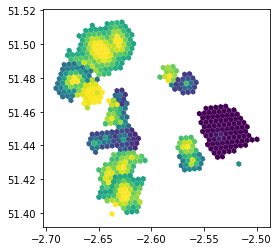

In [ ]:
bats_hex = gpd.read_file(f'{BASE_PATH}/optimization_input/bats_hex_{HEX_RESOLUTION}.geojson',driver='GeoJSON')
moths_hex = gpd.read_file(f'{BASE_PATH}/optimization_input/moths_hex_{HEX_RESOLUTION}.geojson',driver='GeoJSON')

bats_hex['zone_type'] = 'bat'
moths_hex['zone_type'] = 'moth'

activity_zones = pd.concat([bats_hex, moths_hex])
activity_zones.plot(column='likelihood')

For simplicity, we set fixed values for both thresholds. In this case we chose to limit the area only by cost to keep all potential likely areas, even with low likelihood.

In [ ]:
LIKELIHOOD_THRESHOLD = 0.0
COST_THRESHOLD = 0.5  #we designed trheshold to be between 0 and 1 (and infinites for forbidden zones)

hex_costs = pd.read_parquet(f'{BASE_PATH}/optimization_input/costs_hex{HEX_RESOLUTION}.parquet')
hex_costs = hex_costs.melt(id_vars='h3_polyfill', var_name='cost_function', value_name='cost')
hex_costs.head()

h3_polyfill      cost_function         cost
0  8919583926bffff  cost_function_0.5  9999.000000
1  89195839173ffff  cost_function_0.5  9999.000000
2  8919587742bffff  cost_function_0.5     0.484426
3  8919580cad7ffff  cost_function_0.5     0.528847
4  89195875437ffff  cost_function_0.5     0.484426

In [ ]:
activity_zones = activity_zones.merge(hex_costs, left_on='h3_09', right_on='h3_polyfill')
activity_zones.head()

h3_09  label  likelihood  \
0  8919580ca23ffff      2    0.598905   
1  8919580ca23ffff      2    0.598905   
2  8919580ca23ffff      2    0.598905   
3  8919580ca27ffff      2    0.594898   
4  8919580ca27ffff      2    0.594898   

                                            geometry zone_type  \
0  POLYGON ((-2.62517 51.51219, -2.62726 51.51116...       bat   
1  POLYGON ((-2.62517 51.51219, -2.62726 51.51116...       bat   
2  POLYGON ((-2.62517 51.51219, -2.62726 51.51116...       bat   
3  POLYGON ((-2.62204 51.50972, -2.62413 51.50868...       bat   
4  POLYGON ((-2.62204 51.50972, -2.62413 51.50868...       bat   

       h3_polyfill      cost_function         cost  
0  8919580ca23ffff  cost_function_0.5  9999.000000  
1  8919580ca23ffff    cost_function_1  9999.000000  
2  8919580ca23ffff    cost_function_0  9999.000000  
3  8919580ca27ffff  cost_function_0.5     0.725515  
4  8919580ca27ffff    cost_function_1     0.926177

Now we filter the cost for each of the variant of the cost functions we have

In [ ]:
def filter_activity_zone(az):
  # filter thresholds
  az = az.loc[lambda x: x['likelihood']>=LIKELIHOOD_THRESHOLD]
  az = az.loc[lambda x: x['cost']<=COST_THRESHOLD]

  return az

In [ ]:
activity_zones = filter_activity_zone(activity_zones)

We plot the filtered areas. Remember that we have a variant of the map for each cost function

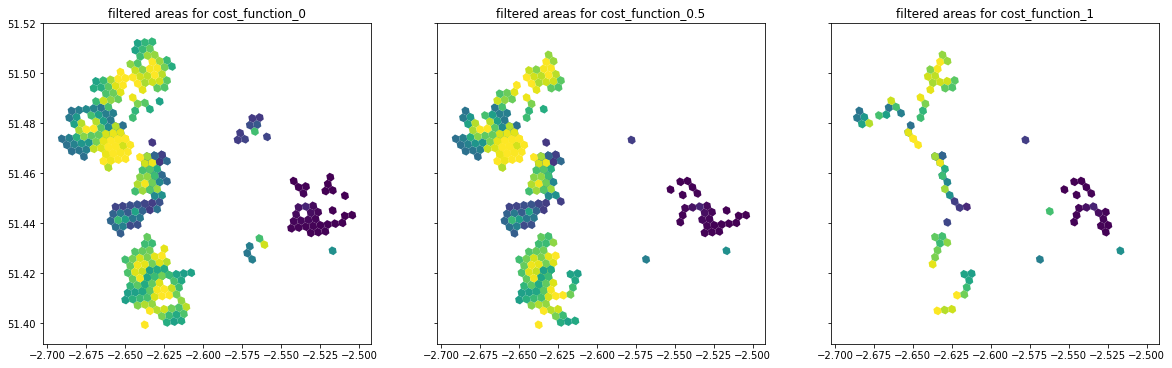

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20,20))

for cost_function, ax in zip(activity_zones.cost_function.unique(), axs.ravel()):
  activity_zones.query("cost_function==@cost_function").plot(column = 'likelihood', ax=ax)
  ax.set_title(f'filtered areas for {cost_function}')
  plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/filtered_areas_{cost_function}.png', dpi = 300)

####5.2.Areas to single points for optimization

To simplify optimization, we assign a single point(hexagon) to each of the areas. to do this, per each cluster(after filtering) we sample randomly one of the most likely points. This will become the start/end of the corridors. We note however that the activity zones will be comprised of multiple polygons.

In the future, this is a possible point of improvement, since the activity zones are comprised of many hexagons and a corridor from one area to another could start in any as long as its cheaper. Nonetheless as long as areas are realitively small this is an useful simplification.

To select a single origin cell grid within each cluster we will sample the centroid of the most likely cells of each cluster. 

We also have to take into account that after filtering by the cost and likelihood thresholds, a cluster might be split into two. To deal with this we identify which are this connected areas create a new cluster label indicating original cluster + 

We also have to considered that we need to repeat this process for each of the different cost functions since the thresholding will allow different potential activity zone hexagons.

In [ ]:
def extract_connected_areas(gdf):
  """Function that extract connected components of a geodataframe"""
  connected_areas = (gpd.GeoDataFrame(
    geometry=[gdf.unary_union], crs=gdf.crs)
  .explode(index_parts=False)
  .reset_index(drop=True)
  .rename_axis('connected_area').reset_index())

  return connected_areas

Run the function for a sample filtering of the zones

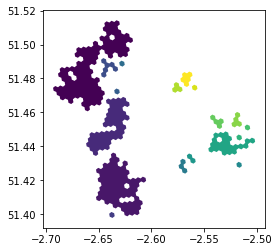

In [ ]:
extract_connected_areas(activity_zones.query("cost_function=='cost_function_0'")).plot(column='connected_area')

In [ ]:
def add_connected_area_id(activity_zones):
  """Extracts connected components and adds the index of the components to the original data"""
  connected_areas = extract_connected_areas(activity_zones)
  return activity_zones.sjoin(connected_areas)

In [ ]:
add_connected_area_id(activity_zones.query("cost_function=='cost_function_0'")).sample(10)

h3_09  label  likelihood  \
1523  89195876a27ffff      2    0.573065   
1472  89195876383ffff     21    1.000000   
719   89195876407ffff      2    0.872238   
140   891958382cbffff      1    0.007817   
362   8919587600bffff     21    0.888170   
1586  89195876ba7ffff      2    0.606885   
191   8919583913bffff      1    0.032520   
983   89195876847ffff     13    0.946995   
1400  89195839e57ffff     11    0.926696   
704   891958763c7ffff     12    1.000000   

                                               geometry zone_type  \
1523  POLYGON ((-2.64408 51.41423, -2.64617 51.41319...      moth   
1472  POLYGON ((-2.65498 51.46722, -2.65707 51.46619...      moth   
719   POLYGON ((-2.63772 51.49792, -2.63981 51.49689...       bat   
140   POLYGON ((-2.51885 51.46023, -2.52094 51.45920...       bat   
362   POLYGON ((-2.65654 51.48055, -2.65863 51.47951...      moth   
1586  POLYGON ((-2.61439 51.40280, -2.61647 51.40177...      moth   
191   POLYGON ((-2.54079 51.44535, -2.54288 51.44431...       bat   
983   POLYGON ((-2.62843 51.42604, -2.63051 51.42500...       bat   
1400  POLYGON ((-2.56116 51.43324, -2.56324 51.43221...      moth   
704   POLYGON ((-2.66438 51.46659, -2.66647 51.46555...       bat   

          h3_polyfill    cost_function      cost  index_right  connected_area  
1523  89195876a27ffff  cost_function_0  0.000000            1               1  
1472  89195876383ffff  cost_function_0  0.000000            0               0  
719   89195876407ffff  cost_function_0  0.005202            0               0  
140   891958382cbffff  cost_function_0  0.454108           14              14  
362   8919587600bffff  cost_function_0  0.000000            0               0  
1586  89195876ba7ffff  cost_function_0  0.023905            1               1  
191   8919583913bffff  cost_function_0  0.331107           10              10  
983   89195876847ffff  cost_function_0  0.095544            1               1  
1400  89195839e57ffff  cost_function_0  0.461798            9               9  
704   891958763c7ffff  cost_function_0  0.000000            0               0

Now we have an identificator of the connected areas added to the data per cost function, we can extract a single hexagon as starting point(or end point) for corridors that connect with the other activity zones.

Now, because of the limitation of representing areas with a single hexagon, if we have connected areas too big the representing hexagon might be too far away from the next area to connect. This is why we will use as starting points a representative with the highest likelihood of a grouping of zone type+cluster+connected area.

This also guarantees that corridors start close to high likelihood activity areas.

In [ ]:
(add_connected_area_id(activity_zones.query("cost_function=='cost_function_0'"))
          .sort_values('likelihood', ascending=False)
          .groupby(['zone_type', 'label', 'connected_area'], sort=False)
          .head(1).reset_index()
          .sample(10)
)

index            h3_09  label  likelihood  \
21   1241  8919583909bffff     24    0.210253   
11    530  8919587612bffff     18    0.850486   
25    221  8919583918fffff      1    0.019410   
23   1466  891958761d3ffff     23    0.169807   
8    1448  89195876163ffff     25    0.980626   
22   1250  891958390cbffff     24    0.206923   
18   1622  89195876db7ffff     11    0.432499   
14    518  8919587611bffff     17    0.636261   
5    1445  89195876153ffff     26    1.000000   
26     98  89195838243ffff      1    0.011322   

                                             geometry zone_type  \
21  POLYGON ((-2.55948 51.47632, -2.56157 51.47528...      moth   
11  POLYGON ((-2.62995 51.45548, -2.63204 51.45445...       bat   
25  POLYGON ((-2.53608 51.45371, -2.53817 51.45268...       bat   
23  POLYGON ((-2.63305 51.47407, -2.63514 51.47304...      moth   
8   POLYGON ((-2.63777 51.45764, -2.63986 51.45660...      moth   
22  POLYGON ((-2.57357 51.47538, -2.57566 51.47434...      moth   
18  POLYGON ((-2.56899 51.42735, -2.57108 51.42631...      moth   
14  POLYGON ((-2.63306 51.46601, -2.63515 51.46498...       bat   
5   POLYGON ((-2.64089 51.46817, -2.64298 51.46714...      moth   
26  POLYGON ((-2.52200 51.45465, -2.52409 51.45362...       bat   

        h3_polyfill    cost_function      cost  index_right  connected_area  
21  8919583909bffff  cost_function_0  0.456456           16              16  
11  8919587612bffff  cost_function_0  0.091357            2               2  
25  8919583918fffff  cost_function_0  0.303559           13              13  
23  891958761d3ffff  cost_function_0  0.004473            5               5  
8   89195876163ffff  cost_function_0  0.000000            2               2  
22  891958390cbffff  cost_function_0  0.467767           15              15  
18  89195876db7ffff  cost_function_0  0.334260            7               7  
14  8919587611bffff  cost_function_0  0.004473            2               2  
5   89195876153ffff  cost_function_0  0.000000            2               2  
26  89195838243ffff  cost_function_0  0.347271           14              14

We define a function to apply the same process given a different filtering of the areas(by cost function and likelihood)

In [ ]:
def get_start_points(activity_zones):
  return (add_connected_area_id(activity_zones)
          .sort_values('likelihood', ascending=False)
          .groupby(['zone_type', 'label', 'connected_area'], sort=False)
          .head(1).reset_index())

Now we create a dataframe processing each of the variants of the map, given by the different cost functions.

In [ ]:
starts = pd.concat(
    map(lambda cf: get_start_points(activity_zones.query('cost_function==@cf')), 
    activity_zones.cost_function.unique()))

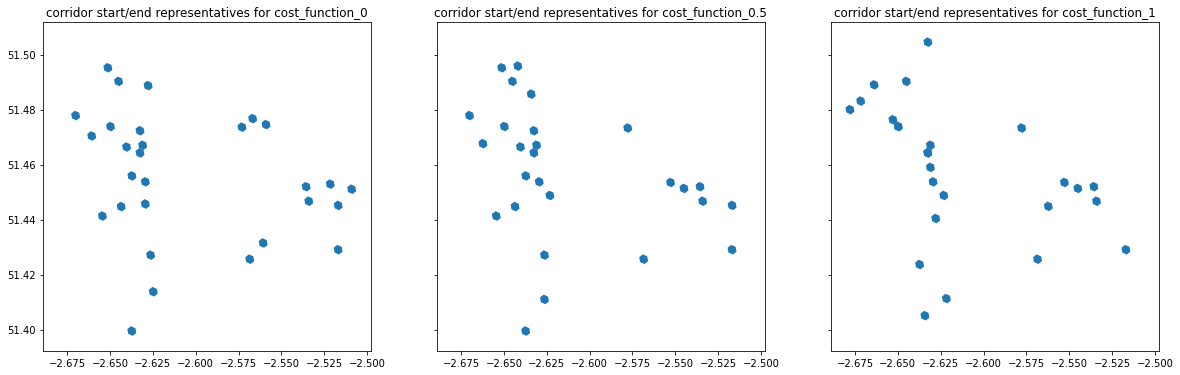

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20,20))

for cost_function, ax in zip(starts.cost_function.unique(), axs.ravel()):
  starts.query("cost_function==@cost_function").plot(ax=ax)
  ax.set_title(f'corridor start/end representatives for {cost_function}')
  plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/points_start_ends_{cost_function}.png', dpi = 300)

####5.3. Conclusions

We have addressed that potential activity areas based on report density are composed of grid cells that fullfill a cost and likelihood conditions, at the same time we have identified potential start and end points that we will use to generate the corridors that connect the different areas.

The filtered areas will be parts of the ecological networks and the start points will be the points to define the corridors that connect these areas.

We note that the whole process is parametrized, the thresholds could be tuned with the aid of experts, looking to give more area to the bats, even if it turns costly or less area. We also note that this process could be replicated to other species, provided apropiate cost function.

###6. Dark corridors optimization

The following notebook finds the most optimal path from point A to point B, according to cost and proximity values. 

To find the most optimal path between the potential starting and ending points of the path.

We use an implementation of the shortest path or Dijkstra algorithm to find the most optimal path. The difference with the original implementation is that the cost of the edges is not the distance, but the cost function that we create in previous notebooks. 

This notebook provides all the possible paths for a single cost function. As we have different cost functions, we run the notebook several times, one for each cost function (or cost configuration) that we have. With the results of this notebook, we can establish which would be the best paths to choose, according to our impact metrics.

####6.1. Read the data

Three main sources for algorithm. The hexagons can be of any dimension, but all files need to have a common dimension.
1. Hexagons with variables for the cost function.
2. JSON representation of a proximity matrix between hexagons.
3. Potential starting points.

In [ ]:
PATH = "/content/drive/MyDrive/GeoNEAS/bat-s4/data"
HEX_RESOLUTION = "hex9"
HEX = "9"
# Loading hexagons with cost variables info.
hex = pd.read_parquet(f"{PATH}/optimization_input/costs_{HEX_RESOLUTION}.parquet")

# Loading proximity data.
with open(f"{PATH}/optimization_input/wr_{HEX_RESOLUTION}.json", "r") as f:
  prox_raw = json.load(f)

# Loading potential starting points.
points = gpd.read_file(f'{PATH}/optimization_input/corridor_starts_{HEX}.geojson')

In [ ]:
hex.head(2)

h3_polyfill  cost_function_0.5  cost_function_1  cost_function_0
0  8919583926bffff             9999.0           9999.0           9999.0
1  89195839173ffff             9999.0           9999.0           9999.0

In [ ]:
points.head(2)

index            h3_09  label  likelihood zone_type      h3_polyfill  \
0    797  8919587647bffff      2         1.0       bat  8919587647bffff   
1    383  8919587603bffff     21         1.0      moth  8919587603bffff   

     cost_function      cost  index_right  connected_area  \
0  cost_function_0  0.003298            0               0   
1  cost_function_0  0.004473            0               0   

                                            geometry  
0  POLYGON ((-2.65182 51.49698, -2.65391 51.49594...  
1  POLYGON ((-2.65028 51.47560, -2.65237 51.47456...

####6.2. Data Preprocessing and Feature engineering
In the following section we:
1. Create proximity matrix in a dense representation. Symetric matrix.
2. Create cost of arriving to an hexagon.
3. Create cost matrix, with (1) and (2) as input.
  - Rows: Origin (from)
  - Cols: Destination (to)

In [ ]:
def create_proximity_matrix(prox_raw) -> pd.DataFrame:
  """Creates proximity matrix from raw JSON values.

    Args:
        prox_raw: JSON file with contiguous hexagons.

    Returns:
        Pandas dataframe with proximity matrix.
  """
  # Create empty proximity matrix.
  hex_id = pd.Series(prox_raw.keys())
  prox_df = pd.DataFrame(0, index=hex_id, 
                        columns=hex_id)

  # Fill proximity values with 1.
  for i in prox_raw.keys():
    for j in prox_raw[i]:
      prox_df.loc[i,j] = 1
      prox_df.loc[j,i] = 1
  
  return prox_df

def get_cost_values(df: pd.DataFrame,
                    col: str) -> pd.DataFrame:
  """Calculates cost values per hexagon.

  The cost value is the cost of passing through an
  hexagon, and it is the value to optimize.

    Args:
        df: Pandas dataframe with cost variables.
        col: Cost function column name.

    Returns:
        Pandas dataframe with cost values per 
        hexagon.
  """
  # Get cost values.
  # TODO(melissa): Replace with the actual cost df.
  cost_df = df[[col]]
  cost_df.index = df['h3_polyfill']
  return cost_df

def create_cost_matrix(prox_df,
                       cost_df) -> pd.DataFrame:
  """Creates cost matrix with proximity matrix.

  The cost of arriving to an hexagon will always 
  be the same, no matter the starting hexagon.

    Args:
        prox_df: Proximity matrix.
        cost_df: Cost dataframe per hexagon.

    Returns:
        Pandas dataframe with cost matrix.
  """
  # Create cost matrix.
  cost_matrix = prox_df.copy()
  not_found = []
  for col in tqdm(cost_matrix.columns):
    try:
      cost = float(cost_df.loc[col])
      cost_matrix[col] = cost_matrix[col] * cost
    # Some values in the cost df are not in the proximity matrix.
    # Save values to identify them.
    except Exception:
      not_found.append(col)
      pass
  return cost_matrix

In [ ]:
# Cost function constant
COST_FUNCTION = "cost_function_1"
# Creating proximity matrix.
prox_df = create_proximity_matrix(prox_raw)
# Extracting cost values.
cost_df = get_cost_values(hex, COST_FUNCTION)
# Creating cost matrix.
cost_matrix = create_cost_matrix(prox_df, cost_df)
# Turn matrix to numpy array.
cost_matrix_np = np.array(cost_matrix)
prox_matrix_np = np.array(prox_df)

  0%|          | 0/3134 [00:00<?, ?it/s]

####6.3. Optimization algorithm.
To create the paths between a starting and an ending point, we implement a variation of the shortest path algorithm. The algorithm is implemented on the Dijkstar library. 

Instead of having the distance between two points as the cost on one edge, we use the cost of arriving to a specific hexagon as cost. Then, we will optimize for the path with the lowest cost.

In [ ]:
# Create graph class for applying shortest path.
graph = Graph()
# Creating vertices with cost values.
for i in tqdm(range(len(cost_matrix_np))):
  for j in range(len(cost_matrix_np)):
    cost = cost_matrix_np[i,j]
    prox = prox_matrix_np[i,j]
    if prox > 0:  # Add only if the hex are contiguous
      # print(f"{i}, {j}")
      graph.add_edge(i, j, cost)

  0%|          | 0/3134 [00:00<?, ?it/s]

In [ ]:
def get_hex_index(
    hex_series: pd.Series, hex_id: str) -> int:
  """Gets hex index based on id."""
  hex_index = hex_series[hex_series==hex_id].index[0]
  return hex_index

def find_best_path(
    start_id: str,
    end_id: str,
    hex_series: pd.Series) -> algorithm.PathInfo:
  """Finds least expensive path between two hexagons.

    Args:
        start_id: Hexagon start id.
        end_id: Hexagon end id.
        hex_series: Series with all hexagon ids.

    Returns:
        PathInfo object from Dijkstar library with
        the most optimal path.
  """
  # Find least expensive path between two hexagons.
  
  start_index = get_hex_index(hex_series, start_id)
  end_index = get_hex_index(hex_series, end_id)
  best_path = find_path(graph, start_index, end_index)
  return best_path

def get_best_path_df(
    start_id: str,
    end_id: str,
    best_path: algorithm.PathInfo,
    hex_series: pd.Series,
    path_id: str) -> pd.DataFrame:
  """Finds least expensive path between two hexagons.

    Args:
        start_id: Hexagon start id.
        end_id: Hexagon end id.
        best_path: PathInfo object from Dijkstar library
        with the most optimal path.
        hex_series: Series with all hexagon ids.
        path_id: String with path id, for identification
          purposes.

    Returns:
        Pandas Dataframe with most optimal path.
  """
  nodes_id = [hex_series[i] for i in best_path.nodes]
  # Create dataframe with optimal path.
  results_dict = {
      "path_id": path_id,
      "start_id": start_id,
      "end_id": end_id,
      "node_number": best_path.nodes,
      "node_id": nodes_id,
      # Cost of first node is equal to 0.
      "cost_node": [0] + best_path.costs,
      # Column type: intermediate, start, end.
      "type": "intermediate"}
  results_df = pd.DataFrame(results_dict)
  # First and last nodes are start and end.
  results_df.iloc[0, results_df.columns.get_loc('type')] = "start"
  results_df.iloc[-1, results_df.columns.get_loc('type')] = "end"
  return results_df

In [ ]:
# Finding a path for each potential point.
best_path_complete_df = pd.DataFrame(
                    columns = ['path_id', 'start_id', 'end_id', 'node_number', 
                               'node_id', 'cost_node', 'type'])
not_feasible = []
feasible = []
path_id = 1
k = 1
# Filtering points per cost function,
final_points = points[points['cost_function']==COST_FUNCTION]
# iteration for finding a path for each potential point.
for start_id in final_points['h3_09']:
  for end_id in final_points['h3_09']:
    if start_id == end_id: continue
    else:
      hex_series = pd.Series(prox_raw.keys())
      try:
        # Find best path.
        best_path = find_best_path(start_id, end_id, hex_series)
        # Get dataframe with best path.
        best_path_df = get_best_path_df(
            start_id, end_id, best_path, hex_series, path_id)
        # Append to complete df for graphing
        best_path_complete_df = best_path_complete_df.append(best_path_df)
        # Count for path id, diferentation purposes when graphing.
        path_id = path_id + 1
        feasible.append((start_id, end_id))
      except Exception:
        not_feasible.append((start_id, end_id))
        pass

In [ ]:
# Asserting that all paths are feasible.
print(f"Feasible paths: {len(feasible)}")
print(f"Not feasible paths: {len(not_feasible)}")

Feasible paths: 646
Not feasible paths: 0


In [ ]:
best_path_complete_df.head()

path_id         start_id           end_id node_number          node_id  \
0       1  8919587603bffff  89195876b83ffff        1926  8919587603bffff   
1       1  8919587603bffff  89195876b83ffff         831  89195876023ffff   
2       1  8919587603bffff  89195876b83ffff         937  89195876027ffff   
3       1  8919587603bffff  89195876b83ffff        2371  891958761cbffff   
4       1  8919587603bffff  89195876b83ffff        1689  891958761cfffff   

   cost_node          type  
0   0.000000         start  
1   0.311469  intermediate  
2   0.326067  intermediate  
3   0.326067  intermediate  
4   0.326067  intermediate

####6.4. Conclusions

This notebook provides all the possible paths for a single cost function. As we have different cost functions, we run the notebook several times, one for each cost function (or cost configuration) that we have. With the results of this notebook, we can establish which would be the best paths to choose, according to our impact metrics.

###7. Corridor network optimization

After the pairwise generation of corridor to connect the zones, we are left with many possible corridors between the areas. Nonetheless, all of these are not necessary to actually connect the network. 

**What we have effectively is a fully connected network of all the areas** where activity areas become nodes and the corridor between two areas becomes an edge. Note that this is a different network than the one we used to find the pairwise minimmal cost paths. 

With this network of activity areas, in order to minimize the paths we can do the following:

1. Delete routes with characteristics(beyond cost) that make them unfeasible, such as routes that connect areas that are more than 2km away. The 2km comes from behavior references of horseshoe bats, since they travel mostly withion 2km of their roosts. 
2. Use a network optimization algoritm to retain the least costly corridors that still allow the same connectivity of the network. That is, that there will still exist a route connecting all nodes 

In [ ]:
BASE_PATH='/content/drive/MyDrive/GeoNEAS/bat-s4/data'
HEX_RESOLUTION = 9

####7.1. Building the corridor network
Here we load the multiple routes that connect the different areas, we transform the input to a graph where activity areas become nodes and the corridor between two areas becomes an edge. Note that this is a different network than the one we used to find the pairwise minimmal cost paths.

There are different files of proposed corridors depending on the variations of the activity zones. We defined the variation of the zones based on cost function changes, thus we have 3 files.

In [ ]:
paths_variations = {
    'cost_function_0': f'{BASE_PATH}/optimization_output/paths_cost_0_hex{HEX_RESOLUTION}.csv',
    'cost_function_0.5': f'{BASE_PATH}/optimization_output/paths_cost_05_hex{HEX_RESOLUTION}.csv',
    'cost_function_1': f'{BASE_PATH}/optimization_output/paths_cost_1_hex{HEX_RESOLUTION}.csv'
}

Lets run the process with one of this and at the end we replicate for all variants

In [ ]:
min_routes = pd.read_csv(paths_variations['cost_function_0.5'])
min_routes.head()

Unnamed: 0  path_id         start_id           end_id  node_number  \
0           0        1  891958763d7ffff  8919587640fffff         2638   
1           1        1  891958763d7ffff  8919587640fffff         2153   
2           2        1  891958763d7ffff  8919587640fffff          904   
3           3        1  891958763d7ffff  8919587640fffff         3054   
4           4        1  891958763d7ffff  8919587640fffff          367   

           node_id  cost_node          type  
0  891958763d7ffff   0.000000         start  
1  8919587639bffff   0.484426  intermediate  
2  89195876067ffff   0.484426  intermediate  
3  89195876077ffff   0.484426  intermediate  
4  8919587600fffff   0.165270  intermediate

In [ ]:
route_costs = min_routes.groupby(['start_id', 'end_id', 'path_id']).agg({'cost_node': 'sum'}).reset_index()

First we filter out routes that might not be viable, one of such would be routes that pass to very high cost areas, such that their weight might be close to the thousands (since we exploded some weights if the hexagons contained points of interests or too many buildings)

Additional filters are also viable, such as filtering routes with a maximum distance (actual distance)

In [ ]:
MAX_ROUTE_COST=100

def filter_routes(route_costs):
  route_costs = route_costs.query('cost_node<@MAX_ROUTE_COST')

  return route_costs

In [ ]:
route_costs = filter_routes(route_costs)

then we build the graph from the filtered routes

In [ ]:
graph = nx.from_pandas_edgelist(route_costs, source='start_id', target='end_id', edge_attr='cost_node')
graph.number_of_nodes(), graph.number_of_edges()

(22, 231)

Note that we have a very big number of connections, in terms of the number of nodes $N$, since we connected all activity zones to each other we have a number of edges $E$ given by

$$
E = \frac{N(N-1)}{2}
$$

Arguably, we might not need to establish a corridor between every pair of activity zones. Especially, considering that establishing a corridor implies a certain cost.

Here we plot the network, using the position of the centroids of the start/end hexagons and showing the connections between them. Note in this case the lines do not represent the actual path of that follows the set of the hexagons of the corridor but rather a direct line, we did this for simplicity in charting

In [ ]:
hex_grid = gpd.read_file(f'{BASE_PATH}/optimization_input/hex{HEX_RESOLUTION}.geojson')

centroids = np.column_stack((hex_grid.centroid.x, hex_grid.centroid.y))
positions = dict(zip(hex_grid.h3_polyfill, centroids))

In [ ]:
def plot_corridor_graph(graph, positions, ax):
  labels = nx.get_edge_attributes(graph,'cost_node')
  edges,weights = zip(*nx.get_edge_attributes(graph, 'cost_node').items())

  nx.draw(
      graph, positions, 
      ax=ax, 
      node_size=100, node_color="darkgreen", edgelist=edges, edge_color=weights, width=0.5, edge_cmap=plt.cm.Blues_r)
  #nx.draw_networkx_edge_labels(graph, positions, edge_labels=labels)

  ax.set_title('Network of activity zones and edges connecting them. Darker edge means lower corridor cost')

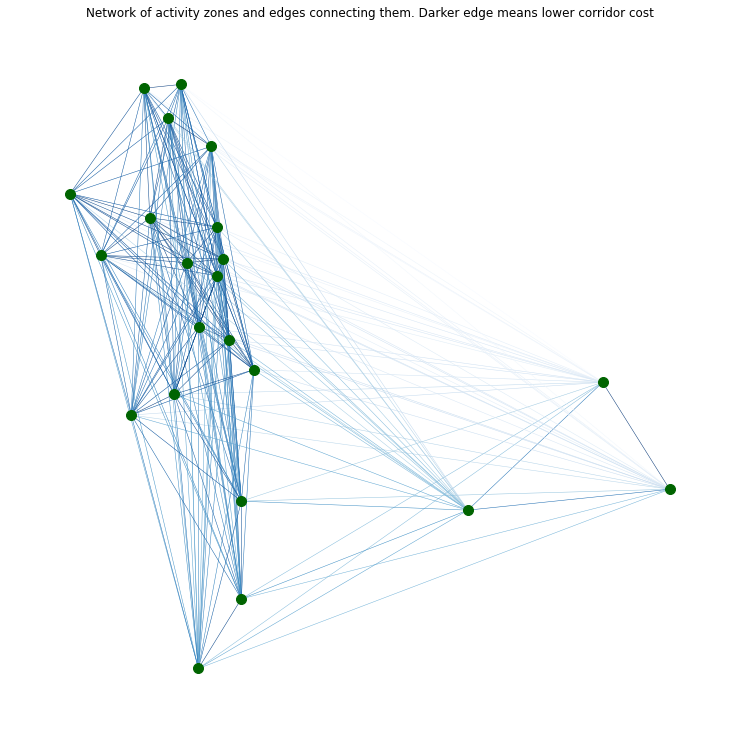

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_corridor_graph(graph, positions, ax=ax)
plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Minimum_paths_graph.png', dpi = 300)
fig.show()

####7.2. Minimum spaññing tree

In order to optimize this network, we propose an scheme where we keep the minimum number of least cost nodes that will still connect the portions of the network.

The minimum spanning tree algorithm allows to obtain a subtree of the network that fulfills our objective https://en.wikipedia.org/wiki/Minimum_spanning_tree

Its implementation from the graph is quite simple.

In [ ]:
optimized_graph = nx.minimum_spanning_tree(graph, weight='cost_node')

The algorithm return a subnetwork that is actually a tree

In [ ]:
optimized_graph.number_of_nodes(), optimized_graph.number_of_edges()

(22, 21)

With this, we have greatly reduced the number of necessary edges to connect the different nodes.

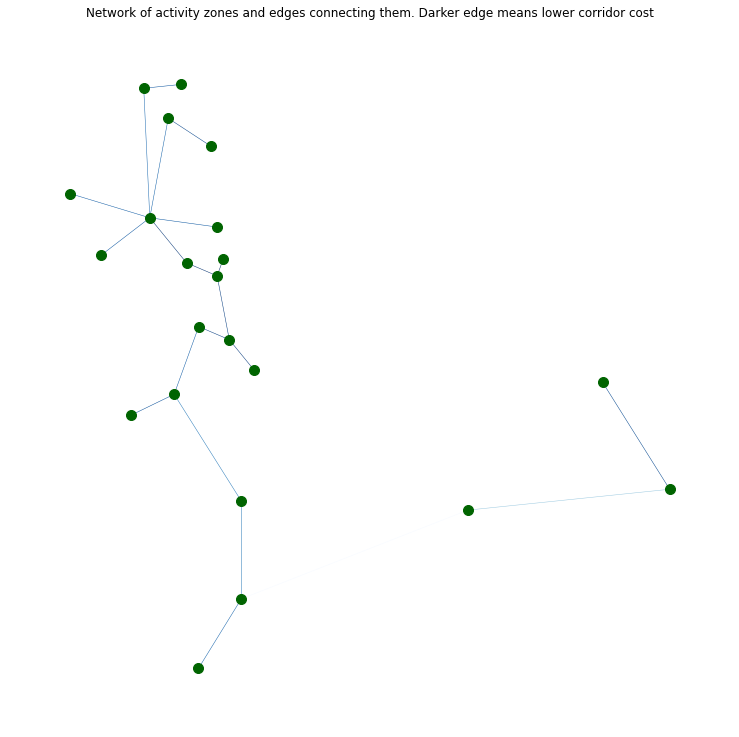

In [ ]:
fig, ax = plt.subplots(figsize=(13, 13))
plot_corridor_graph(optimized_graph, positions, ax=ax)
plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Minimum_spaning_tree.png', dpi = 300)
fig.show()

From this tree, we can filter the original routes

In [ ]:
def filter_optimized_routes(min_routes, optimized_graph):
  optimized_edges = nx.to_pandas_edgelist(optimized_graph)
  optimized_routes = min_routes.merge(
      optimized_edges[['source', 'target']], 
      left_on=('start_id', 'end_id'), right_on=('source', 'target'), 
      how='inner')

  return optimized_routes.drop(columns=['source', 'target'])

In [ ]:
optimized_routes = filter_optimized_routes(min_routes, optimized_graph)

optimized_routes.path_id.nunique()

21

####7.3. Processiong all map variations

We will abstract the process in a function for the different cost functions versions that we have

In [ ]:
def optimize_routes(min_routes):
  route_costs = min_routes.groupby(['start_id', 'end_id']).agg({'cost_node': 'sum'}).reset_index()
  
  # filter routes with certain conditions
  route_costs = filter_routes(route_costs)

  # create networkx graph
  graph = nx.from_pandas_edgelist(route_costs, source='start_id', target='end_id', edge_attr='cost_node')
  
  # calculate minimum spanning tree
  optimized_graph=nx.minimum_spanning_tree(graph, weight='cost_node')

  # filter original min_routes to optimized paths
  optimized_routes = filter_optimized_routes(min_routes, optimized_graph)

  return optimized_routes

In [ ]:
optimize_routes(min_routes)

Unnamed: 0  path_id         start_id           end_id  node_number  \
0             0       32  8919587640fffff  8919587647bffff         2794   
1             1       32  8919587640fffff  8919587647bffff          122   
2             2       32  8919587640fffff  8919587647bffff         1140   
3             3       32  8919587640fffff  8919587647bffff         1347   
4             0       53  8919587603bffff  891958763d7ffff         1926   
..          ...      ...              ...              ...          ...   
129           3      589  891958391abffff  89195839c07ffff         2579   
130           4      589  891958391abffff  89195839c07ffff         1839   
131           5      589  891958391abffff  89195839c07ffff         1185   
132           6      589  891958391abffff  89195839c07ffff         2975   
133           7      589  891958391abffff  89195839c07ffff         2004   

             node_id  cost_node          type  
0    8919587640fffff   0.000000         start  
1    8919587640bffff   0.465295  intermediate  
2    89195876447ffff   0.512030  intermediate  
3    8919587647bffff   0.477604           end  
4    8919587603bffff   0.000000         start  
..               ...        ...           ...  
129  89195839ccbffff   0.128918  intermediate  
130  89195839ccfffff   0.161302  intermediate  
131  89195839c1bffff   0.167301  intermediate  
132  89195839c03ffff   0.167231  intermediate  
133  89195839c07ffff   0.166362           end  

[134 rows x 8 columns]

In [ ]:
results = []

for cf, path in tqdm(paths_variations.items()):
  min_routes = pd.read_csv(paths_variations[cf])
  optimized_routes = optimize_routes(min_routes)
  
  optimized_routes['cost_function'] = cf
  results.append(optimized_routes)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
all_optimized_routes = pd.concat(results)
all_optimized_routes.sample(5)

Unnamed: 0  path_id         start_id           end_id  node_number  \
76            0      388  89195839c07ffff  89195876db7ffff         2004   
38            1       73  8919587603bffff  891958761d3ffff         3129   
372           6      690  891958391abffff  89195839c07ffff         1038   
142           2       98  8919587606fffff  8919587611bffff         1529   
362          15      487  89195839c07ffff  89195839e57ffff         2426   

             node_id  cost_node          type      cost_function  
76   89195839c07ffff   0.000000         start    cost_function_1  
38   89195876033ffff   0.452618  intermediate  cost_function_0.5  
372  89195839c8fffff   0.000000  intermediate    cost_function_0  
142  8919587602bffff   0.000000  intermediate    cost_function_0  
362  89195839ec3ffff   0.544750  intermediate    cost_function_0

####7.4. Conclusions

From many corridors that were calculated in the minimum cost path optimization, we could now map a network where nodes were activity zones and edges were corridors, with the edge cost summing the costs of the grid cells that composed the corridor.

We saw that many of those proposed corridors were redundant or that could be optimized to reduce the number of required corridors to connect the zones.

With this step we can now proceed to build and visualize the full ecological network (activity areas + corridors connecting them)

### 8. Impact measures

In this section impact measures will be calculated considering the area of influence of bats and cost of light. Indicators were calcualted per cost function.

The indicator of area considered current area of influence of baths and the future area and corridors for commute.

The indicador of cost of light considers the percentage of decrease to obtain comfortable lights for bats commutes. This decrease is monetize with a literature review value of 80 euros to completely turn off a streetlight

In [ ]:
BASE_PATH='/content/drive/MyDrive/GeoNEAS/bat-s4/data'
HEX_RESOLUTION = 9

####8.1. Mapping the routes

We are going to map the routes per cost of function

In [ ]:
base_map = gpd.read_file(f'{BASE_PATH}/optimization_input/hex{HEX_RESOLUTION}.geojson')

costs = {"1" : 0, "0":0, "05":0}

for i in costs.keys():

  cost = i
  min_routes = pd.read_csv(f'{BASE_PATH}/optimization_output/paths_cost_{cost}_hex9.csv')
  costs[i] = min_routes

In [ ]:
for i in costs.keys():

  print("The number of feasible routes for cost {} is {}".format(i, len(costs[i].path_id.unique())))

The number of feasible routes for cost 1 is 646
The number of feasible routes for cost 0 is 812
The number of feasible routes for cost 05 is 702


We identify several routes in the optimization. We are going to visualize five random routes and analyse the optimal routes calculate in the section 7.

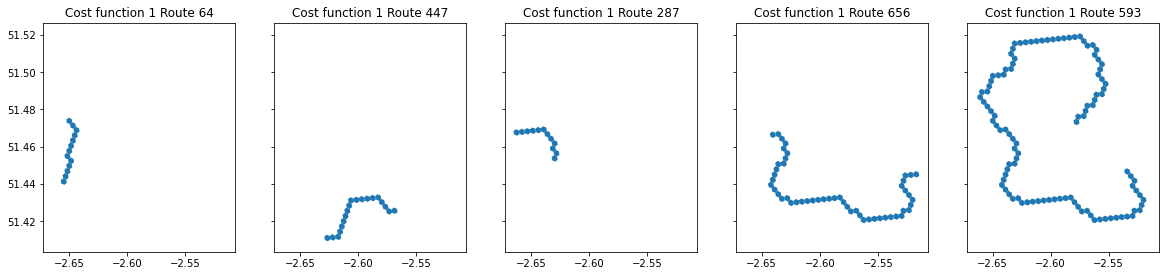

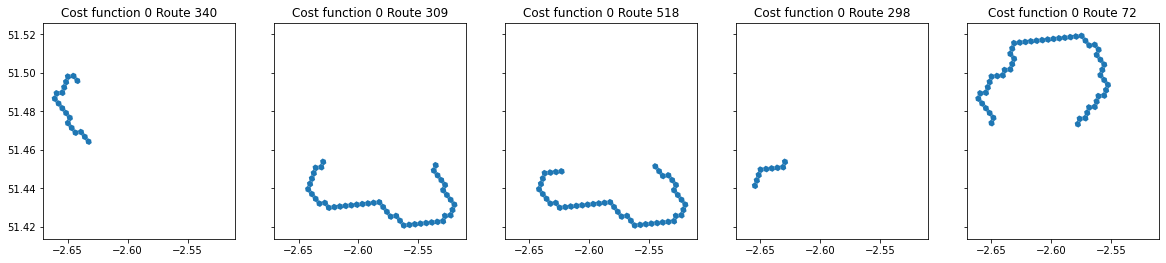

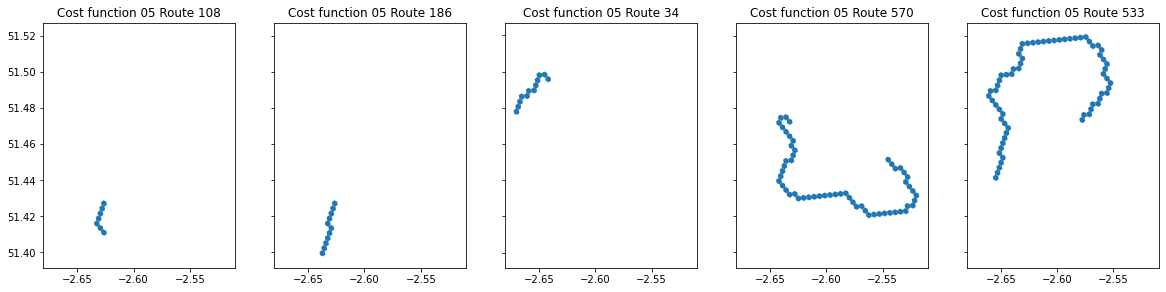

In [ ]:
#fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,20))
import random 

for cost_function in costs.keys(): 

  fig, axs = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(20,20))

  for path_ids, ax in zip(random.choices(costs[i].path_id.unique(), k = 5), axs.ravel()):

    route = costs[i][costs[i].path_id == path_ids]["node_id"]

    base_map[base_map.h3_polyfill.isin(route)].plot(ax=ax)

    ax.set_title(f'Cost function {cost_function} Route {path_ids}')

#### 8.2. Mapping the optimal routes

In [ ]:
optimize_routes = pd.read_csv(f'{BASE_PATH}/results/optimized_routes_hex{HEX_RESOLUTION}.csv')
activity_zones = gpd.read_file(f'{BASE_PATH}/results/activity_zones_hex{HEX_RESOLUTION}.geojson')

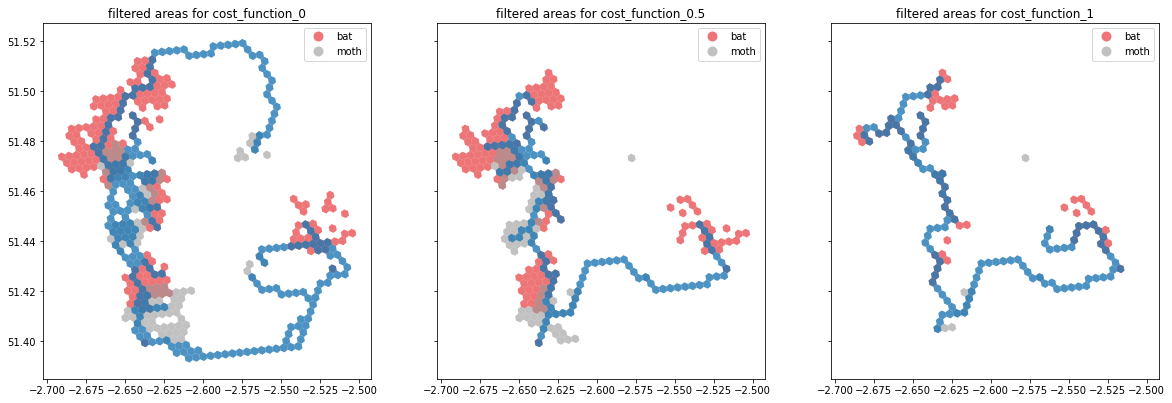

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20,20))

for cost_function, ax, cost_function2 in zip(activity_zones.cost_function.unique(), axs.ravel(), costs.keys()):
  
  activity_zones.query("cost_function==@cost_function").plot(column = 'zone_type', 
                                                             legend = True,
                                                             categorical = True,
                                                             cmap = "Set1",
                                                             alpha = 0.6,
                                                             ax=ax)
  
  routes = optimize_routes[optimize_routes.cost_function == cost_function]["node_id"]
  

  base_map[base_map.h3_polyfill.isin(routes)].plot(alpha = 0.8,
                                                ax=ax)

  ax.set_title(f'filtered areas for {cost_function}')
  plt.savefig(f'/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Optimize_paths_{cost_function}.png', dpi = 300)

We identify that the optimization algothitms connect the bats location with the moths minimizing the defined cost function. Each cost function increase the area of influence of the bats consequently we are going to calculate the change in this indicator.

####8.3. Area comparisons


In [ ]:
EXPORT_CRS = 'EPSG:4326'
LOCAL_CRS = 'EPSG:27700'

activity_zones.to_crs(LOCAL_CRS, inplace = True)
activity_zones["area"] = activity_zones.area

base_map.to_crs(LOCAL_CRS, inplace = True)
base_map["area"] = base_map.area

bats_hex = gpd.read_file(f'{BASE_PATH}/optimization_input/bats_hex_{HEX_RESOLUTION}.geojson',driver='GeoJSON')
moths_hex = gpd.read_file(f'{BASE_PATH}/optimization_input/moths_hex_{HEX_RESOLUTION}.geojson',driver='GeoJSON')

bats_hex.to_crs(LOCAL_CRS, inplace = True)
bats_hex["area"] = bats_hex.area

In [ ]:
cost_function = ["cost_function_0", "cost_function_1", "cost_function_0.5"]

current = []
future = []
change_perc = []

for i in cost_function:

  act_hex = list(bats_hex[(bats_hex.likelihood >= 0.5)]["h3_09"])

  fut_hex = list(activity_zones[(activity_zones.zone_type == "bat") &
                                (activity_zones.cost_function == i)]["h3_polyfill"].values)
  
  future_routes = list(optimize_routes[optimize_routes.cost_function == i]["node_id"].values)

  final_routes = future_routes

  for j in fut_hex:
    try:
      final_routes.remove(j)
    except:
      pass

  
  current_area = base_map[base_map.h3_polyfill.isin(act_hex)]["area"].sum()/10000
  routes_area = base_map[base_map.h3_polyfill.isin(final_routes)]["area"].sum()/10000
  future_area = base_map[base_map.h3_polyfill.isin(fut_hex)]["area"].sum()/10000
  future_final = routes_area + future_area

  change = ((future_final - current_area)/current_area)*100

  change = round(change, 2)

  current.append(current_area)
  future.append(future_final)
  change_perc.append(change)
  
  print(f"In the {i} the current area for bats moving is {round(current_area,2)}, the future area with the optimization will be {round(future_area,2)}, a percentage change of {change} %")

dict_results = {"Cost_function" : cost_function, "Current_area" : current, "Future_area" : future, "Perc_change" : change}
results = pd.DataFrame.from_dict(dict_results)

In the cost_function_0 the current area for bats moving is 2095.44, the future area with the optimization will be 2027.07, a percentage change of 79.05 %
In the cost_function_1 the current area for bats moving is 2095.44, the future area with the optimization will be 672.32, a percentage change of -30.24 %
In the cost_function_0.5 the current area for bats moving is 2095.44, the future area with the optimization will be 1627.61, a percentage change of 10.7 %


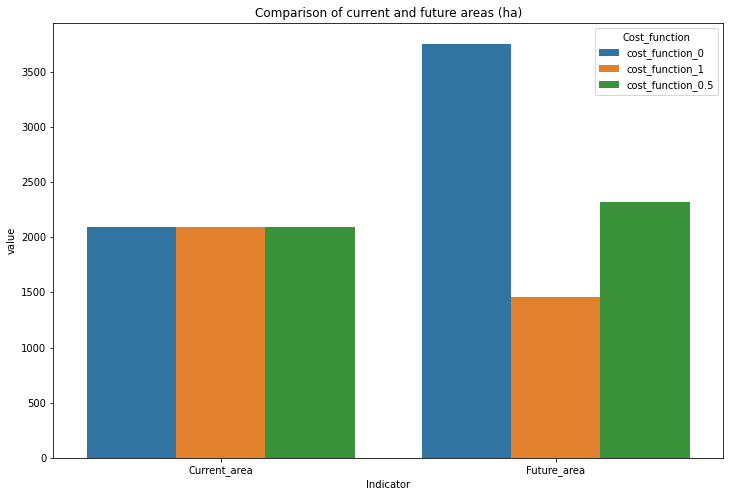

In [ ]:
df = results.melt(id_vars = ["Cost_function"], var_name = "Indicator")

fig = plt.figure(figsize = (12, 8))

sns.barplot(data = df[df.Indicator.isin(["Current_area", "Future_area"])], 
            x = "Indicator", y = "value", hue = "Cost_function")

#plt.bar(df["Indicator"][df.Indicator.isin(["Current_area", "Future_area"])], df["value"][df.Indicator.isin(["Current_area", "Future_area"])])

#plt.xticks(df.Crime)
plt.title("Comparison of current and future areas (ha)".format(i))
plt.savefig('/content/drive/MyDrive/GeoNEAS/bat-s4/Images/Area_Bats_comparisons.png', dpi = 300)
plt.show()

As a metric to measure the impact of our proposed solution, we considered three scenarios for the construction of dark corridors for the commute and unburned by light. In the first one, we considered most of the weight to human needs, which refers to the presence of light (cost function 0);in the second, we equally weighted the need for light for humans and the need of bats for darkness and space to move (cost function 0.5); and in the third, most of the weight was given to the bat preference for darkness and space to move around (cost function 1). In the principal cases, the ones where the needs of humans and bats are balanced and the ones where the needs of humans were given preference, an increase of area for dark corridors was seen. In the balanced case, the increase was 10.7% and in the case, for only humans, the increase was 79.03%. When the preference for bats behaviour is analyse a decrease of 30.24% of the area is observed because the locations where bat are comfartable is less than the current; however, cost functions were defined considering literature reviews and data analysis and we could pass some information. This tool need to be calibrate with biology experts in order to defined cost functions and obtain relevant results. Finally, this shows that our implementation gives a path for the improvement of conditions for the Horseshoe bat.

####8.4. Light savings

In [ ]:
hex_var = gpd.read_file(BASE_PATH + f"/optimization_input/hex9.geojson")

In [ ]:
cost_function = ["cost_function_0", "cost_function_1", "cost_function_0.5"]

future = []
change_perc = []

cost = 80 #euros

for i in cost_function:

  #act_hex = list(bats_hex[(bats_hex.likelihood >= 0.5)]["h3_09"])

  fut_hex = list(activity_zones[(activity_zones.zone_type == "bat") &
                                (activity_zones.cost_function == i)]["h3_polyfill"].values)
  
  future_routes = list(optimize_routes[optimize_routes.cost_function == i]["node_id"].values)

  final_routes = future_routes

  for j in fut_hex:
    try:
      final_routes.remove(j)
    except:
      pass

  
  #current_area = base_map[base_map.h3_polyfill.isin(act_hex)]["area"].sum()/10000

  routes_area = hex_var[hex_var.h3_polyfill.isin(final_routes)]
  future_area = hex_var[hex_var.h3_polyfill.isin(fut_hex)]

  routes_area["light_savings"] = (routes_area.cost_light*(80/1))*(routes_area.N_lights)
  future_area["light_savings"] = (future_area.cost_light*(80/1))*(future_area.N_lights)

  savings = routes_area.light_savings.sum() + future_area.light_savings.sum()


  
  print(f"In the {i} the savings will be {round(savings,2)} euros")

In the cost_function_0 the savings will be 57931.9 euros
In the cost_function_1 the savings will be 66148.92 euros
In the cost_function_0.5 the savings will be 39802.22 euros


Money savings for decrease in lightning were calculated considering a cost of 80 euros for turn off completely a streetlight. With the number of streetlights and the cots of light to obtain a comfortable threshold for bat commute the savings were measured. The cost function that prioritise bats commute (alpha = 0) save 60K euros in the summer follow by the cost function that prioritises human being impact (alpha = 1) with 57 euros in the summer. Finally, the balanced cost function (alpha = 0.5) save 40 K euros in the summer. This is an approximation considering multiple sources, the Bristol government could refine this measures with detail data of cost and street lights specifications.

####8.5. Conclusions

This sections shows the optimal routes per cost function. This routes connects the bats locations with the mots in order to give the minimim cost route considering impact and resistance factors. Furthermore, impact measures were calculated, finding that bats area of influence increase for two of three cost functions. The cost function related to bats resistance decrease their area but it could be due to constant factors that could be calibrate with experst. Finally, costs savings due to decrease of light were measured. In-deep calculations could be conducted by Bristol government.

### 9. Final conclusions and limitations

As a metric to measure the impact of our proposed solution, we considered three scenarios for the construction of dark corridors for the commute and unburned by light. In the first one, we considered most of the weight to human needs, which refers to the presence of light (cost function 0);in the second, we equally weighted the need for light for humans and the need of bats for darkness and space to move (cost function 0.5); and in the third, most of the weight was given to the bat preference for darkness and space to move around (cost function 1). In the principal cases, the ones where the needs of humans and bats are balanced and the ones where the needs of humans were given preference, an increase of area for dark corridors was seen. In the balanced case, the increase was 10.7% and in the case, for only humans, the increase was 79.03%. When the preference for bats behavior is analyzed a decrease of 30.24% of the area is observed because the locations where bats are comfortable is less than the current; however, cost functions were defined considering literature reviews and data analysis and we could pass some information. This tool needs to be calibrated with biology experts in order to define cost functions and obtain relevant results. Finally, this shows that our implementation gives a path for the improvement of conditions for the Horseshoe bat.

Another metric of impact that we consider was money saved. Money savings for the decrease in lightning were calculated considering a cost of 80 euros for turning off a streetlight completely. With the number of streetlights and the costs of light to obtain a comfortable threshold for bat commute the savings were measured. The cost function that prioritizes bats commute (alpha = 0) saves 60K euros in the summer followed by the cost function that prioritizes human impact (alpha = 1) with 57 euros in the summer. Finally, the balanced cost function (alpha = 0.5) saves 40 K euros in the summer. This is an approximation considering multiple sources, the Bristol government could refine these measures with detailed data of cost and street lights specifications. We considered the saving in two scenarios:
In the scenario where we consider the needs of men and bats equally, the total savings are 39,802 euros. 
In the scenario where we only consider the needs of bats, the savings were 66,148 euros.

The solution has limitations related to the bats and moths granularity. Observations are static and does not have timestamp preventing seasonality calculations. In the future, data gathering must be improved considering installation of GPS and sensors to detect bats and moths. Furthermore, lights saving estimations could be improved when the monitoring systems is working, this allow decisionmakers to take choice in real time and to calculate precise indicators about impact on human beings and fauna. Crimes should be monitorized considering georeferenced data to determinate if dark ecological corridors are influencing this incidents. On the other hand, biology experts and bat specialists are crucual to define resistancefunction while decision makers could help in the impact function. To involve those experts in the decision give flexibility to the solution and space to improve it.


## 🖼️ Visualisations

**Bats and moths locations**

![Number_crimes_general.png](https://storage.googleapis.com/geoneas-bucket/bat-s4/Images/Bats_locations.png)

**Radiance**

![Number_crimes_general.png](https://storage.googleapis.com/geoneas-bucket/bat-s4/Images/Radiance.png)

**Optimal paths between bats and moths**

![Number_crimes_general.png](https://storage.googleapis.com/geoneas-bucket/bat-s4/Images/Minimum_spaning_tree.png)


**Bats area (current scenario vs future scenario)**

![Number_crimes_general.png](https://storage.googleapis.com/geoneas-bucket/bat-s4/Images/Area_Bats_comparisons.png)

## 👓 References

[1]Kuijper, D.P.J., Schut, J., van Dullemen, D., Toorman, H., Goossens, N., Ouwehand, J. & Limpens, H.J.G.A. (2008) Experimental evidence of light disturbance along the commuting routes of pond bats (Myotis dasycneme). Lutra, 51, 37-49.  

[2] Stone E.L., Jones G. & Harris S. (2012) Conserving energy at a cost to biodiversity? Impacts of LED lighting on bats. Global Change Biology, 18, 2458-2465.

[3]Pears, Alan (June 1998). "Chapter 7: Appliance technologies and scope for emission reduction".

[4]Arlettaz, R., Godat, S., and Meyer, H (2000) Competition for food by expanding pipistrelle bat populations (Pipistrellus pipistrellus) might contribute to the decline of lesser horseshoe bats (Rhinolophus hipposideros). Biological Conservation, 93, 55-60.

[5]McInnes, Leland & Healy, John & Astels, Steve. (2017). hdbscan: Hierarchical density based clustering. The Journal of Open Source Software. 2. 10.21105/joss.00205. 

[6]Uber hexagon grid. https://eng.uber.com/h3/

[7] Numpy and Scipy Documentation — Numpy and Scipy documentation. Retrieved 2021-12-10. A minimum spanning tree is a graph consisting of the subset of edges which together connect all connected nodes, while minimizing the total sum of weights on the edges.

[8]Dijkstra, E. W. (1959). "A note on two problems in connection with graphs". Numerische Mathematik. 1: 269–271

[9] Foraging and commuting habitats of the greater horseshoe bat, revealed by high-resolution GPS- tracking


## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
